In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams['figure.figsize'] = (10, 7)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
# Load data
data = pd.read_csv("./data/Train.csv")
test_data = pd.read_csv("./data/Test.csv")
variable_definitions = pd.read_csv("./data/VariableDefinitions.csv")
sample_submission = pd.read_csv("./data/SampleSubmission.csv")

data.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Exploratory data analysis

Here we perform some exploratory data analysis to have first impression on how the features and target variables are looking.

### Type of the Problem
It is a classification problem where we have to predict whether individuals are most likely to have or use a bank account or not. In a classification problem, we have to predict discrete values based on a given set of independent variable.

In [ ]:
# Some general dataset information
print(f"The shape of the training data: {data.shape}")
print(f"The shape of the test data: {test_data.shape}")

data.describe(include="all")

The shape of the training data: (23524, 13)
The shape of the test data: (10086, 12)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524.000000,23524,23524,23524,23524,23524.000000,23524.000000,23524,23524,23524,23524,23524
unique,4,NaN,8735,2,2,2,NaN,NaN,2,6,5,6,10
top,Rwanda,NaN,uniqueid_1,No,Rural,Yes,NaN,NaN,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,NaN,4,20212,14343,17454,NaN,NaN,13877,12831,10749,12791,6437
mean,NaN,2016.975939,NaN,NaN,NaN,NaN,3.797483,38.805220,NaN,NaN,NaN,NaN,NaN
std,NaN,0.847371,NaN,NaN,NaN,NaN,2.227613,16.520569,NaN,NaN,NaN,NaN,NaN
min,NaN,2016.000000,NaN,NaN,NaN,NaN,1.000000,16.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,2016.000000,NaN,NaN,NaN,NaN,2.000000,26.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,2017.000000,NaN,NaN,NaN,NaN,3.000000,35.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2018.000000,NaN,NaN,NaN,NaN,5.000000,49.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.info(verbose=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 15.6 MB


This shows the list of variables, sizes and data types in each variables. This will help you to know what feature engineering you can apply. We do not have any missing value.

#### Univariate Analysis
In this section, we will do univariate analysis. It is the simplest form of analysing data where we examine each variable individually. For categorical features we can use frequency table or bar plots which will calculate the number of each category in a particular variable. For numerical features, probability density plots can be used to look at the distribution of the variable.

bank_account
No     20212
Yes     3312
Name: count, dtype: int64


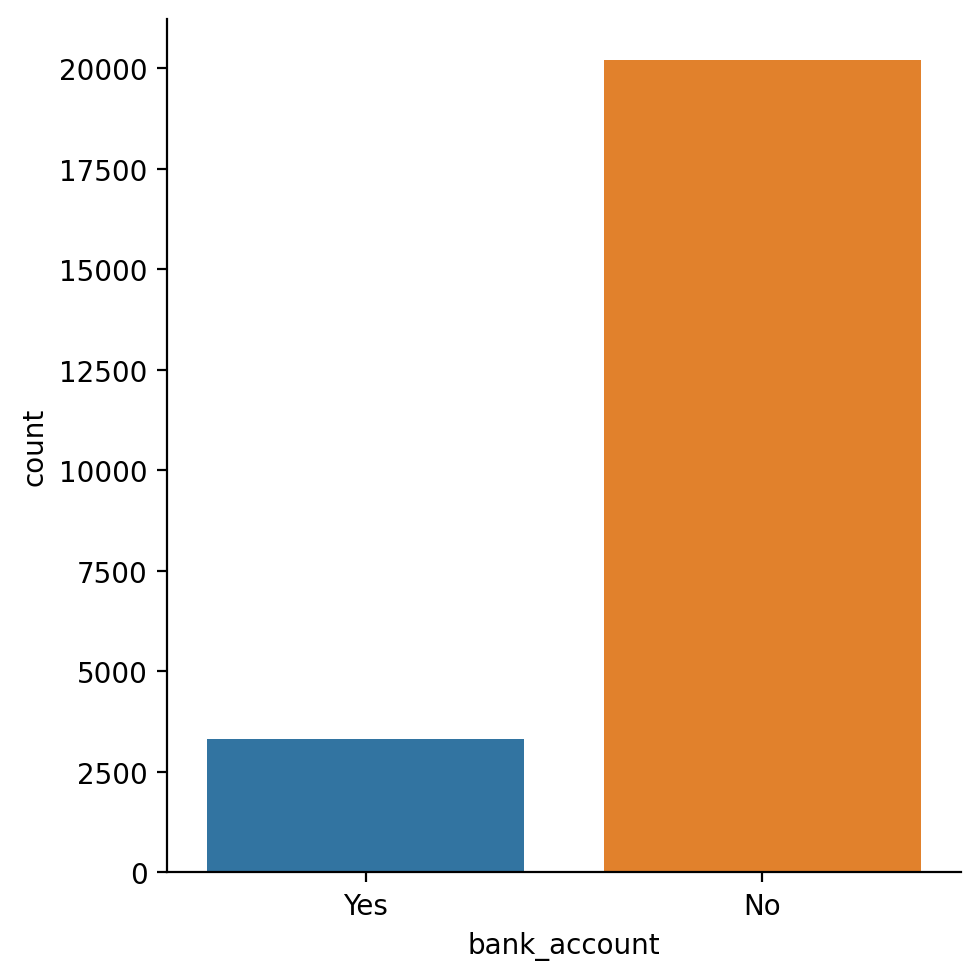

In [ ]:
# Frequency table of a variable will give us the count of each category in that Target variable.
print(data["bank_account"].value_counts())

# Plotting this
sns.catplot(x="bank_account", hue="bank_account", kind="count", data=data)

There is a big class unbalance, we are going to handle this later.

Let's explore some other variable distribution.

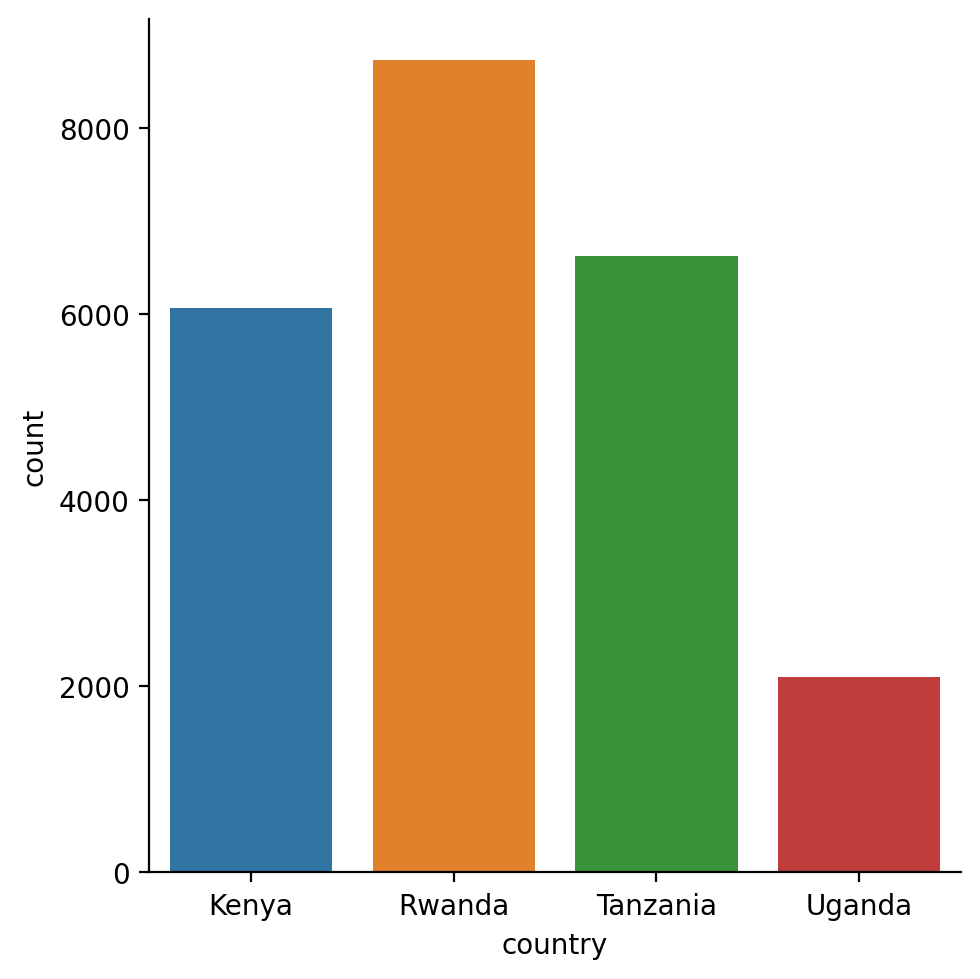

In [ ]:
# Explore Country distribution

sns.catplot(x="country", kind="count", data=data, hue="country")

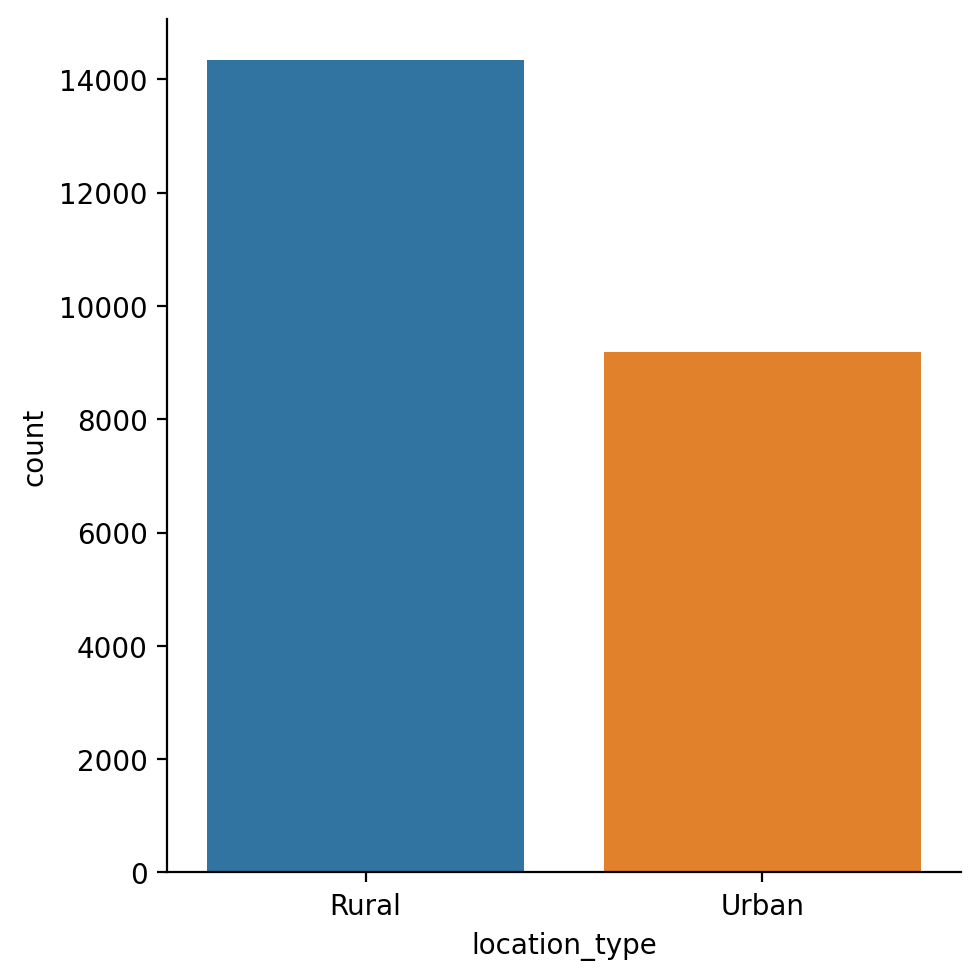

In [ ]:
# Explore Location distribution

sns.catplot(x="location_type", kind="count", data=data, hue="location_type")

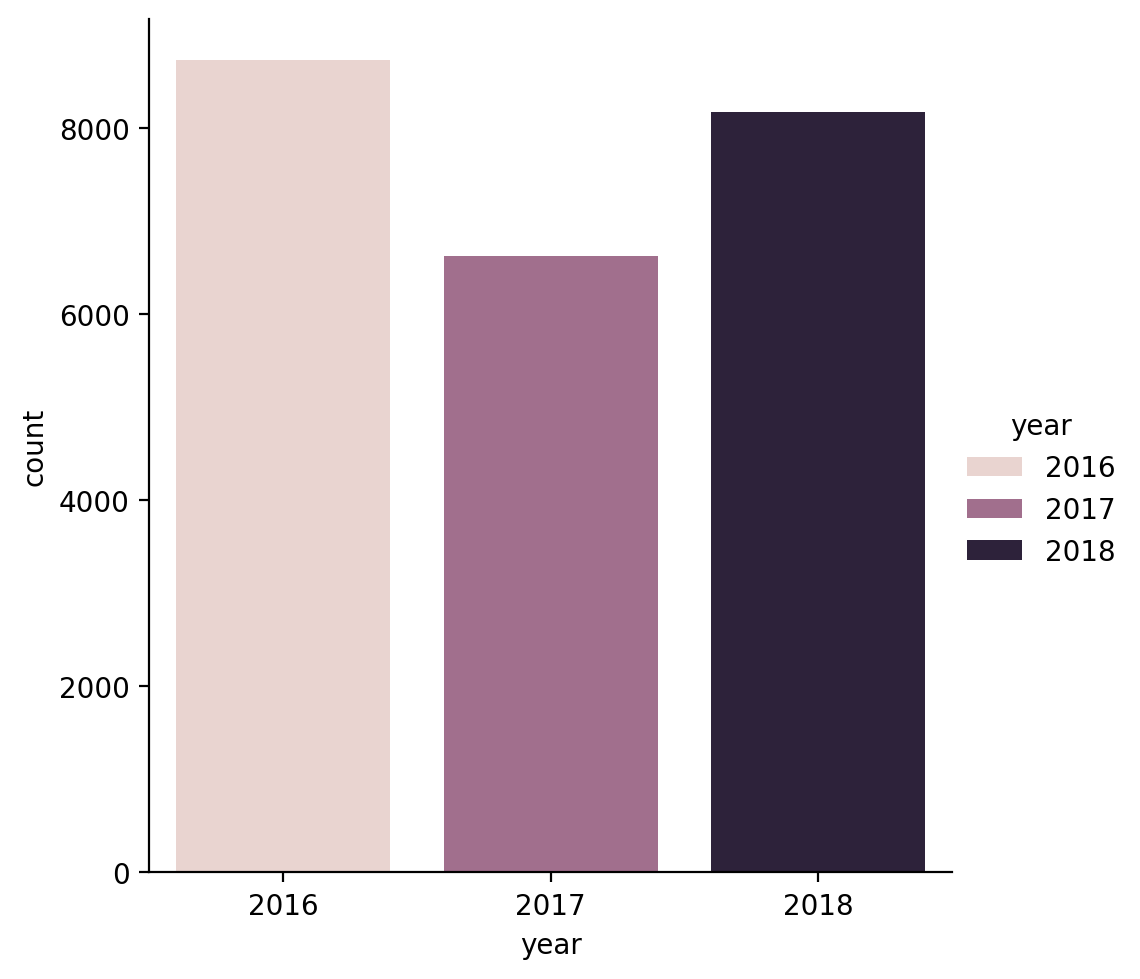

In [ ]:
# Explore Years distribution

sns.catplot(x="year", kind="count", data=data, hue="year")

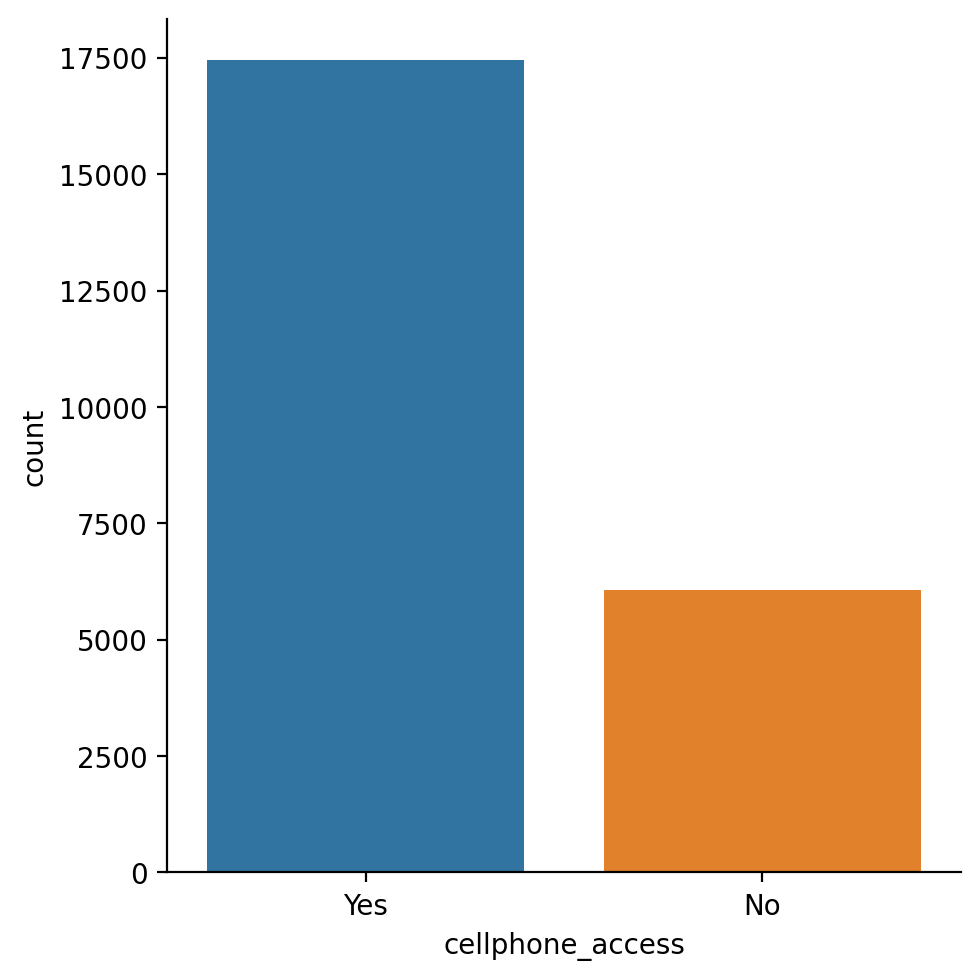

In [ ]:
# Explore cellphone_access distribution

sns.catplot(x="cellphone_access", kind="count", data=data, hue="cellphone_access")

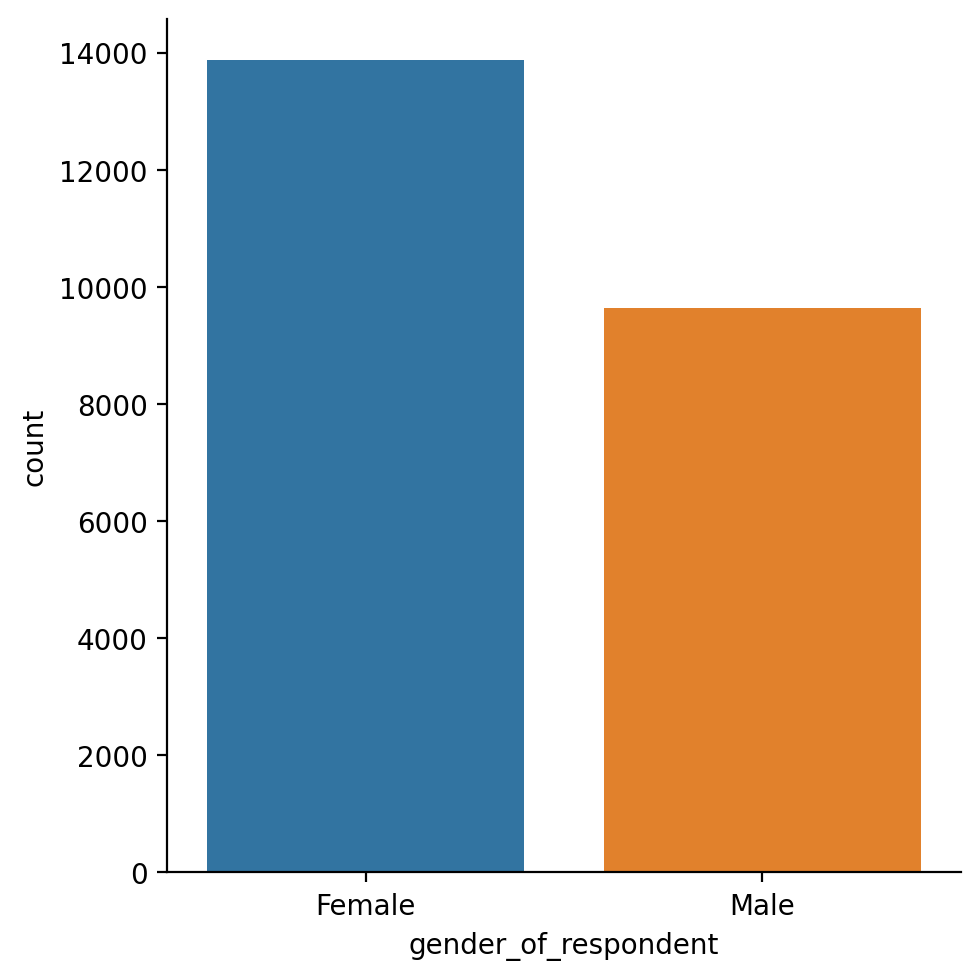

In [ ]:
# Gender balance distribution

sns.catplot(
    x="gender_of_respondent", kind="count", data=data, hue="gender_of_respondent"
)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Spouse'),
  Text(1, 0, 'Head of Household'),
  Text(2, 0, 'Other relative'),
  Text(3, 0, 'Child'),
  Text(4, 0, 'Parent'),
  Text(5, 0, 'Other non-relatives')])

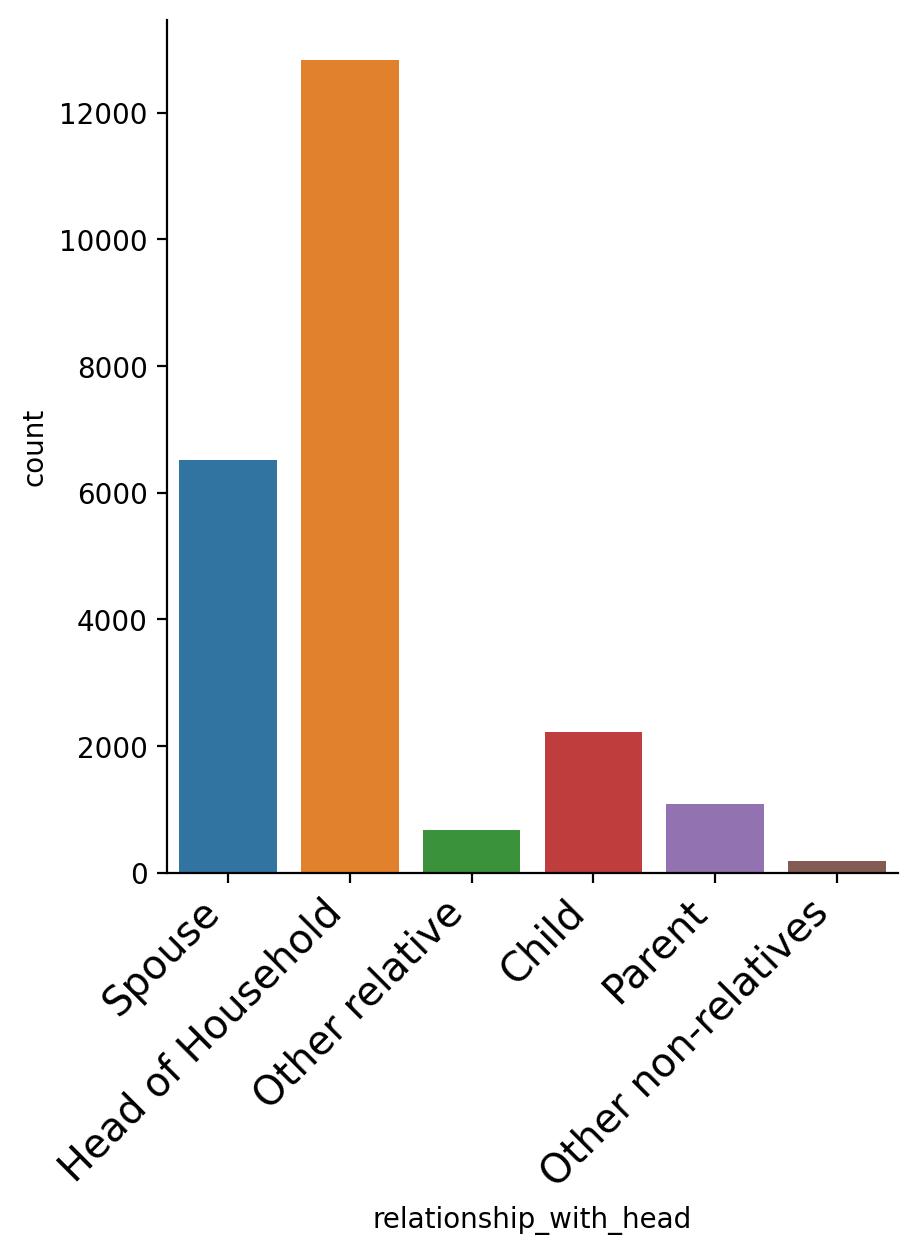

In [ ]:
# Explore relationship_with_head distribution

sns.catplot(
    x="relationship_with_head", kind="count", data=data, hue="relationship_with_head"
)

plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'Married/Living together'),
  Text(1, 0, 'Widowed'),
  Text(2, 0, 'Single/Never Married'),
  Text(3, 0, 'Divorced/Seperated'),
  Text(4, 0, 'Dont know')])

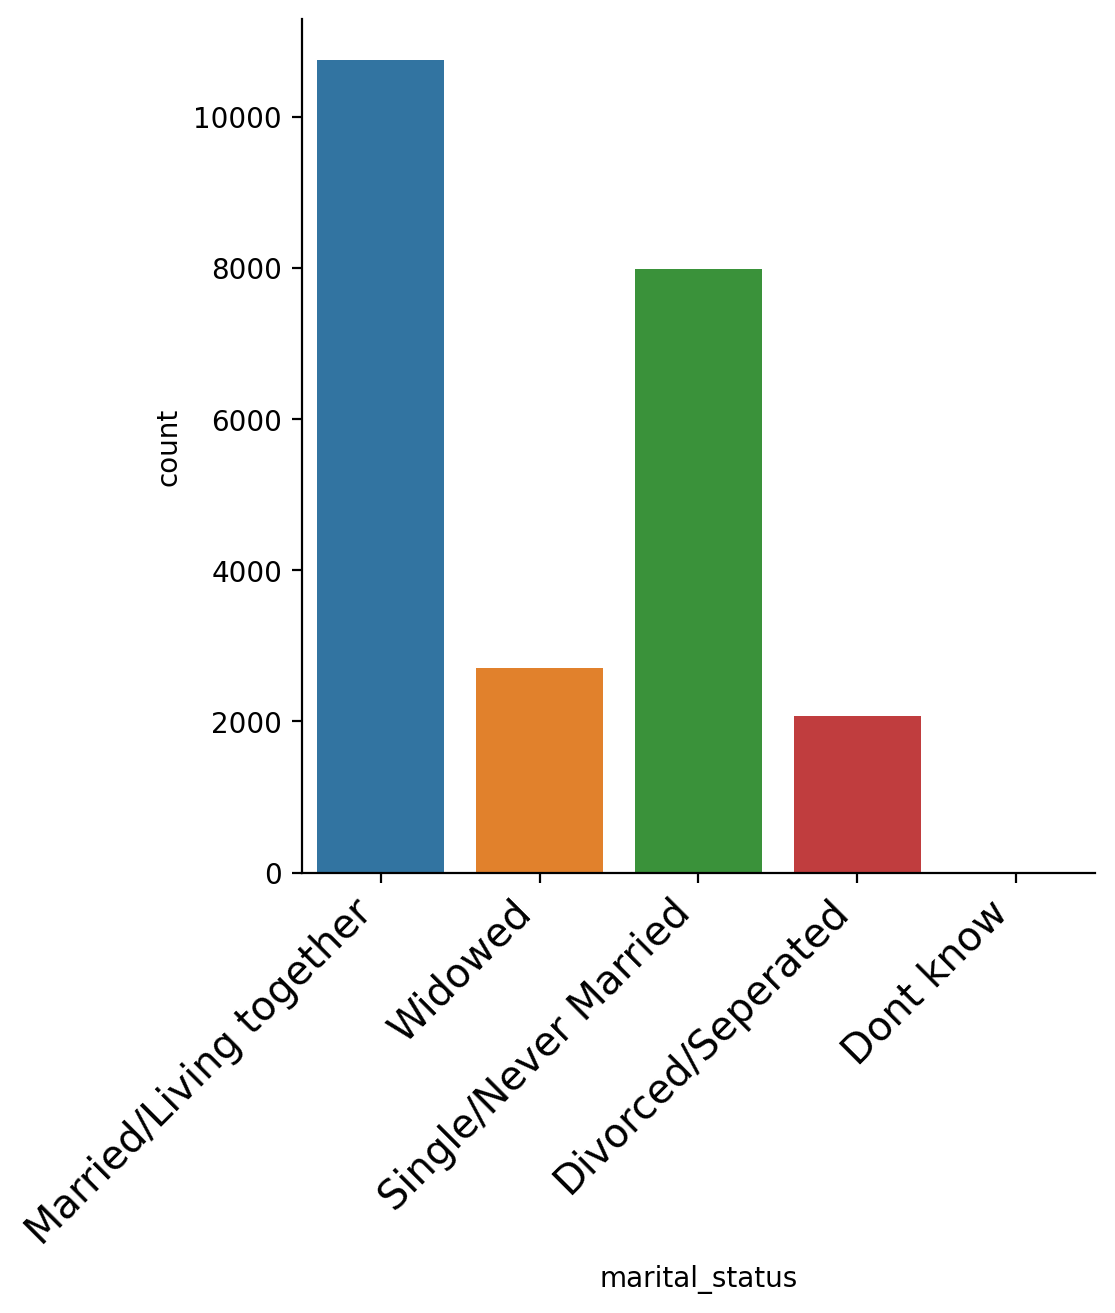

In [ ]:
# Explore marital_status  distribution

sns.catplot(x="marital_status", kind="count", data=data, hue="marital_status")

plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Secondary education'),
  Text(1, 0, 'No formal education'),
  Text(2, 0, 'Vocational/Specialised training'),
  Text(3, 0, 'Primary education'),
  Text(4, 0, 'Tertiary education'),
  Text(5, 0, 'Other/Dont know/RTA')])

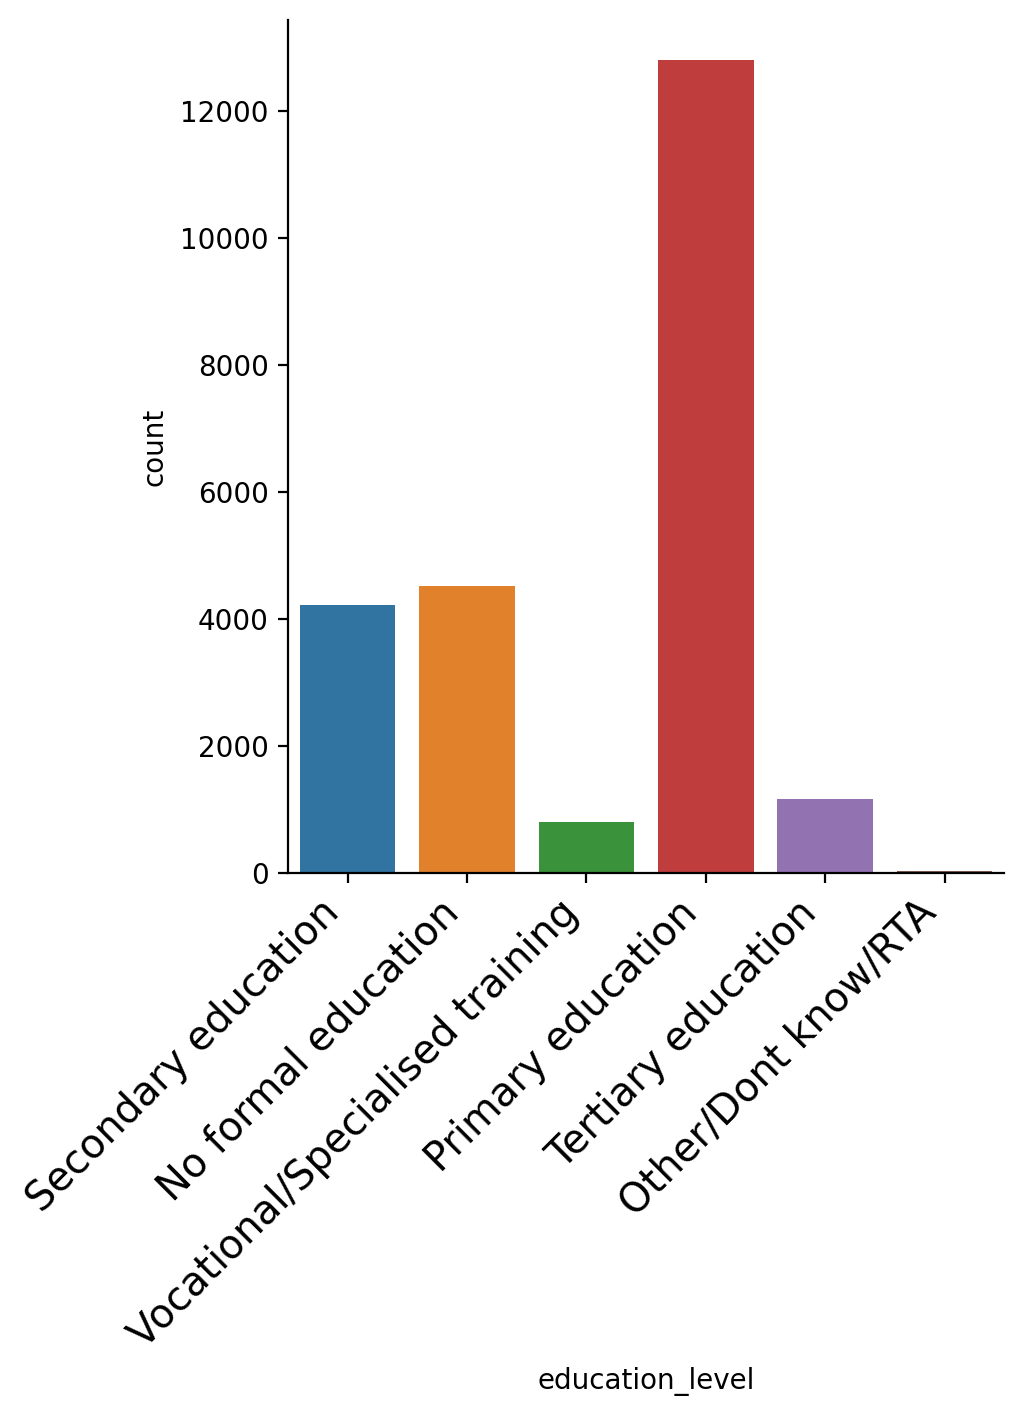

In [ ]:
# Explore education_level  distribution

sns.catplot(x="education_level", kind="count", data=data, hue="education_level")

plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Self employed'),
  Text(1, 0, 'Government Dependent'),
  Text(2, 0, 'Formally employed Private'),
  Text(3, 0, 'Informally employed'),
  Text(4, 0, 'Formally employed Government'),
  Text(5, 0, 'Farming and Fishing'),
  Text(6, 0, 'Remittance Dependent'),
  Text(7, 0, 'Other Income'),
  Text(8, 0, 'Dont Know/Refuse to answer'),
  Text(9, 0, 'No Income')])

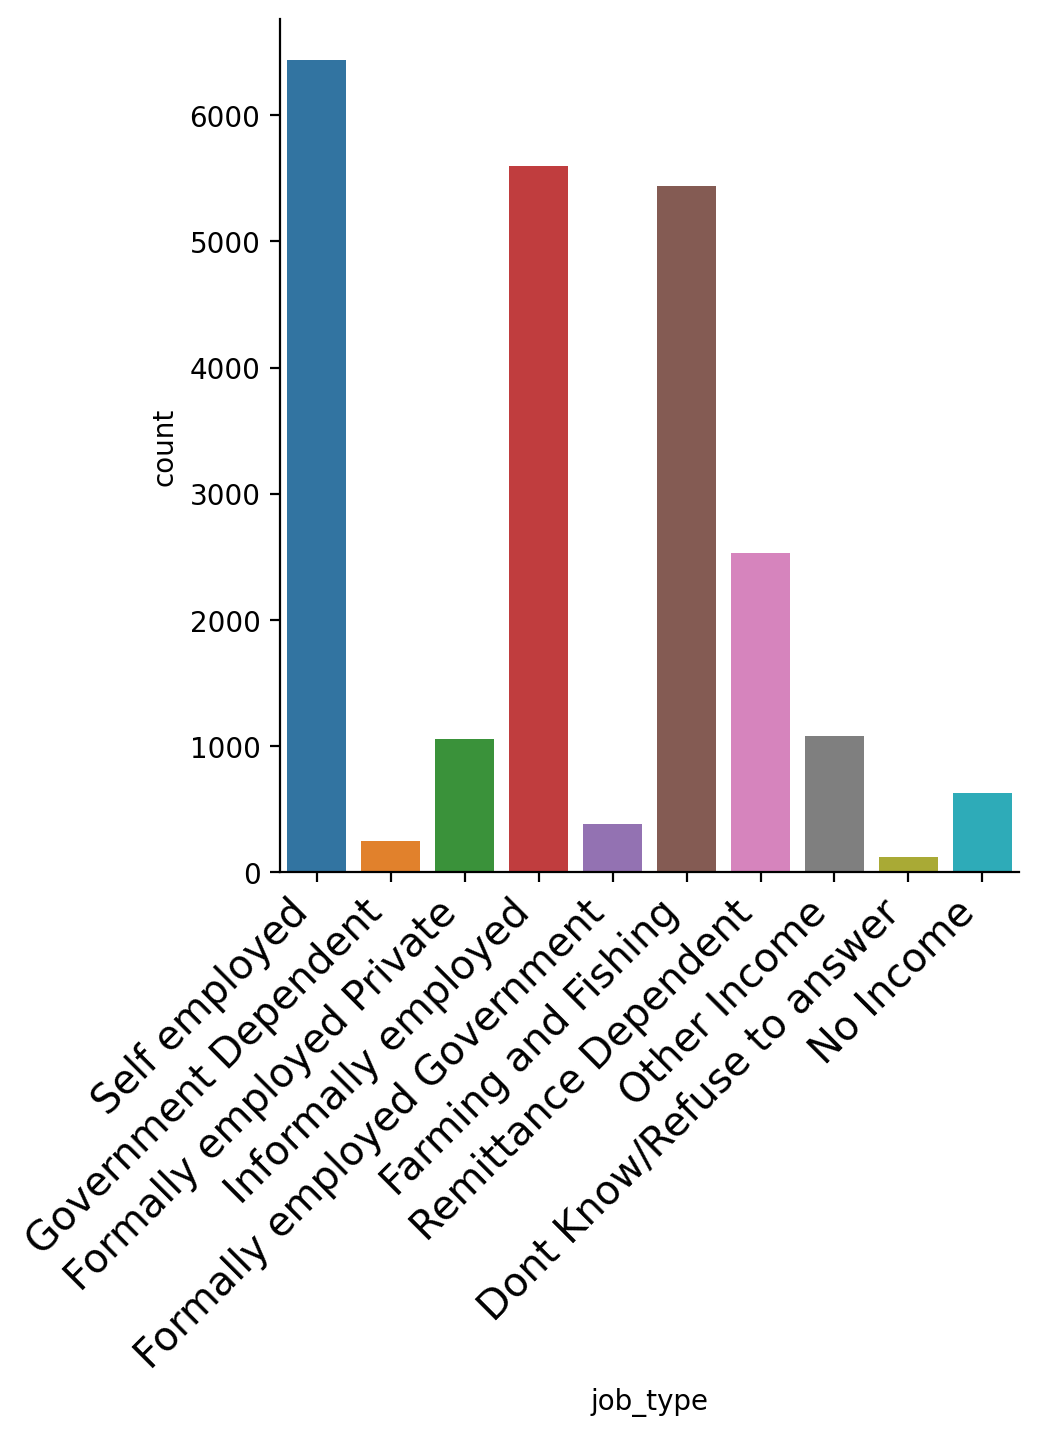

In [ ]:
# Explore job_type distribution


sns.catplot(x="job_type", kind="count", data=data, hue="job_type")

plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

Text(0.5, 0, 'Age of Respondent')

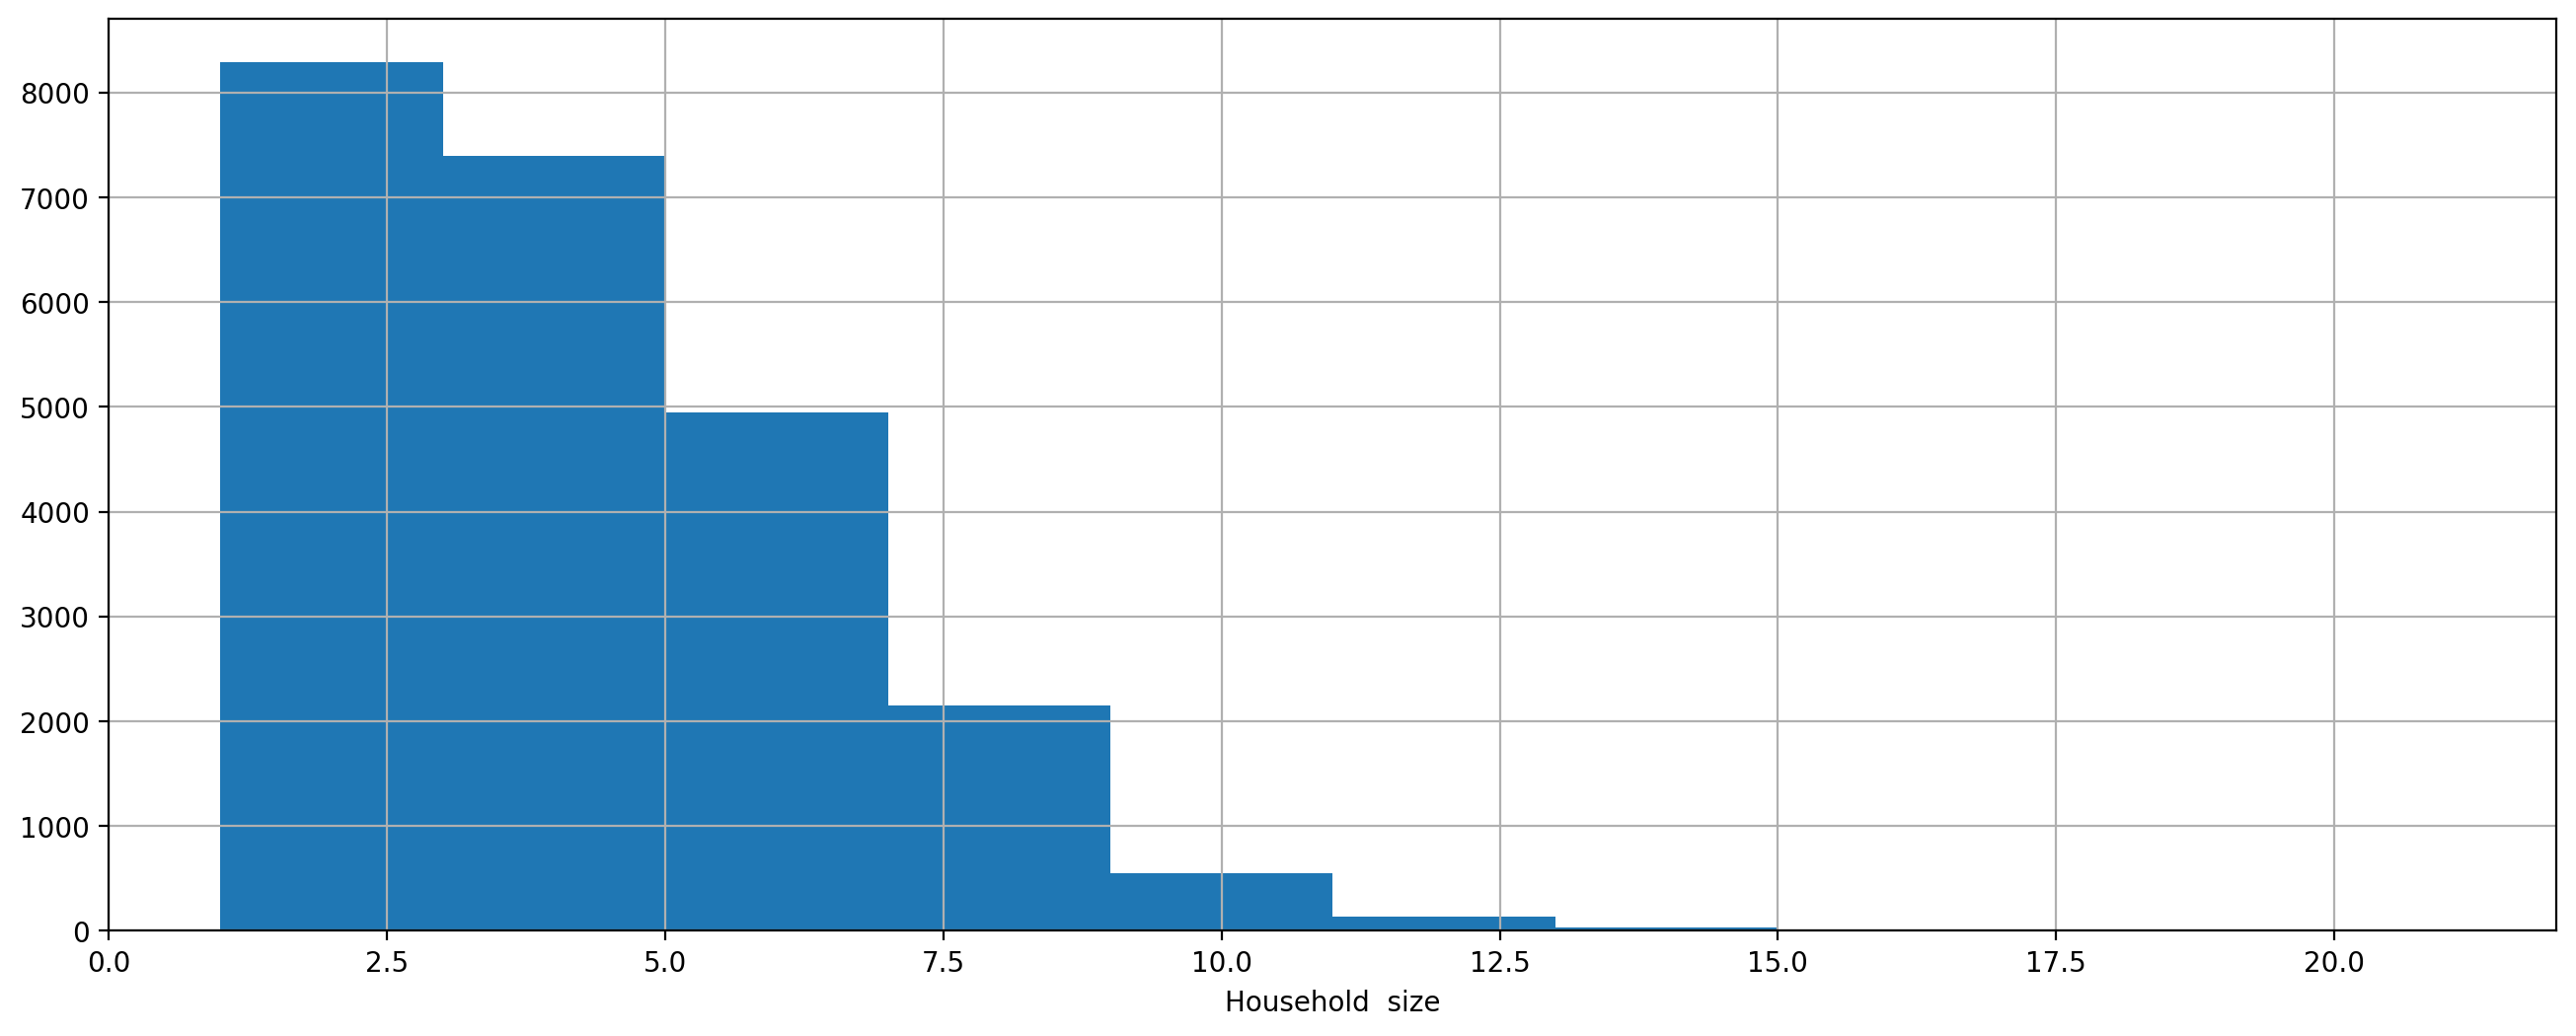

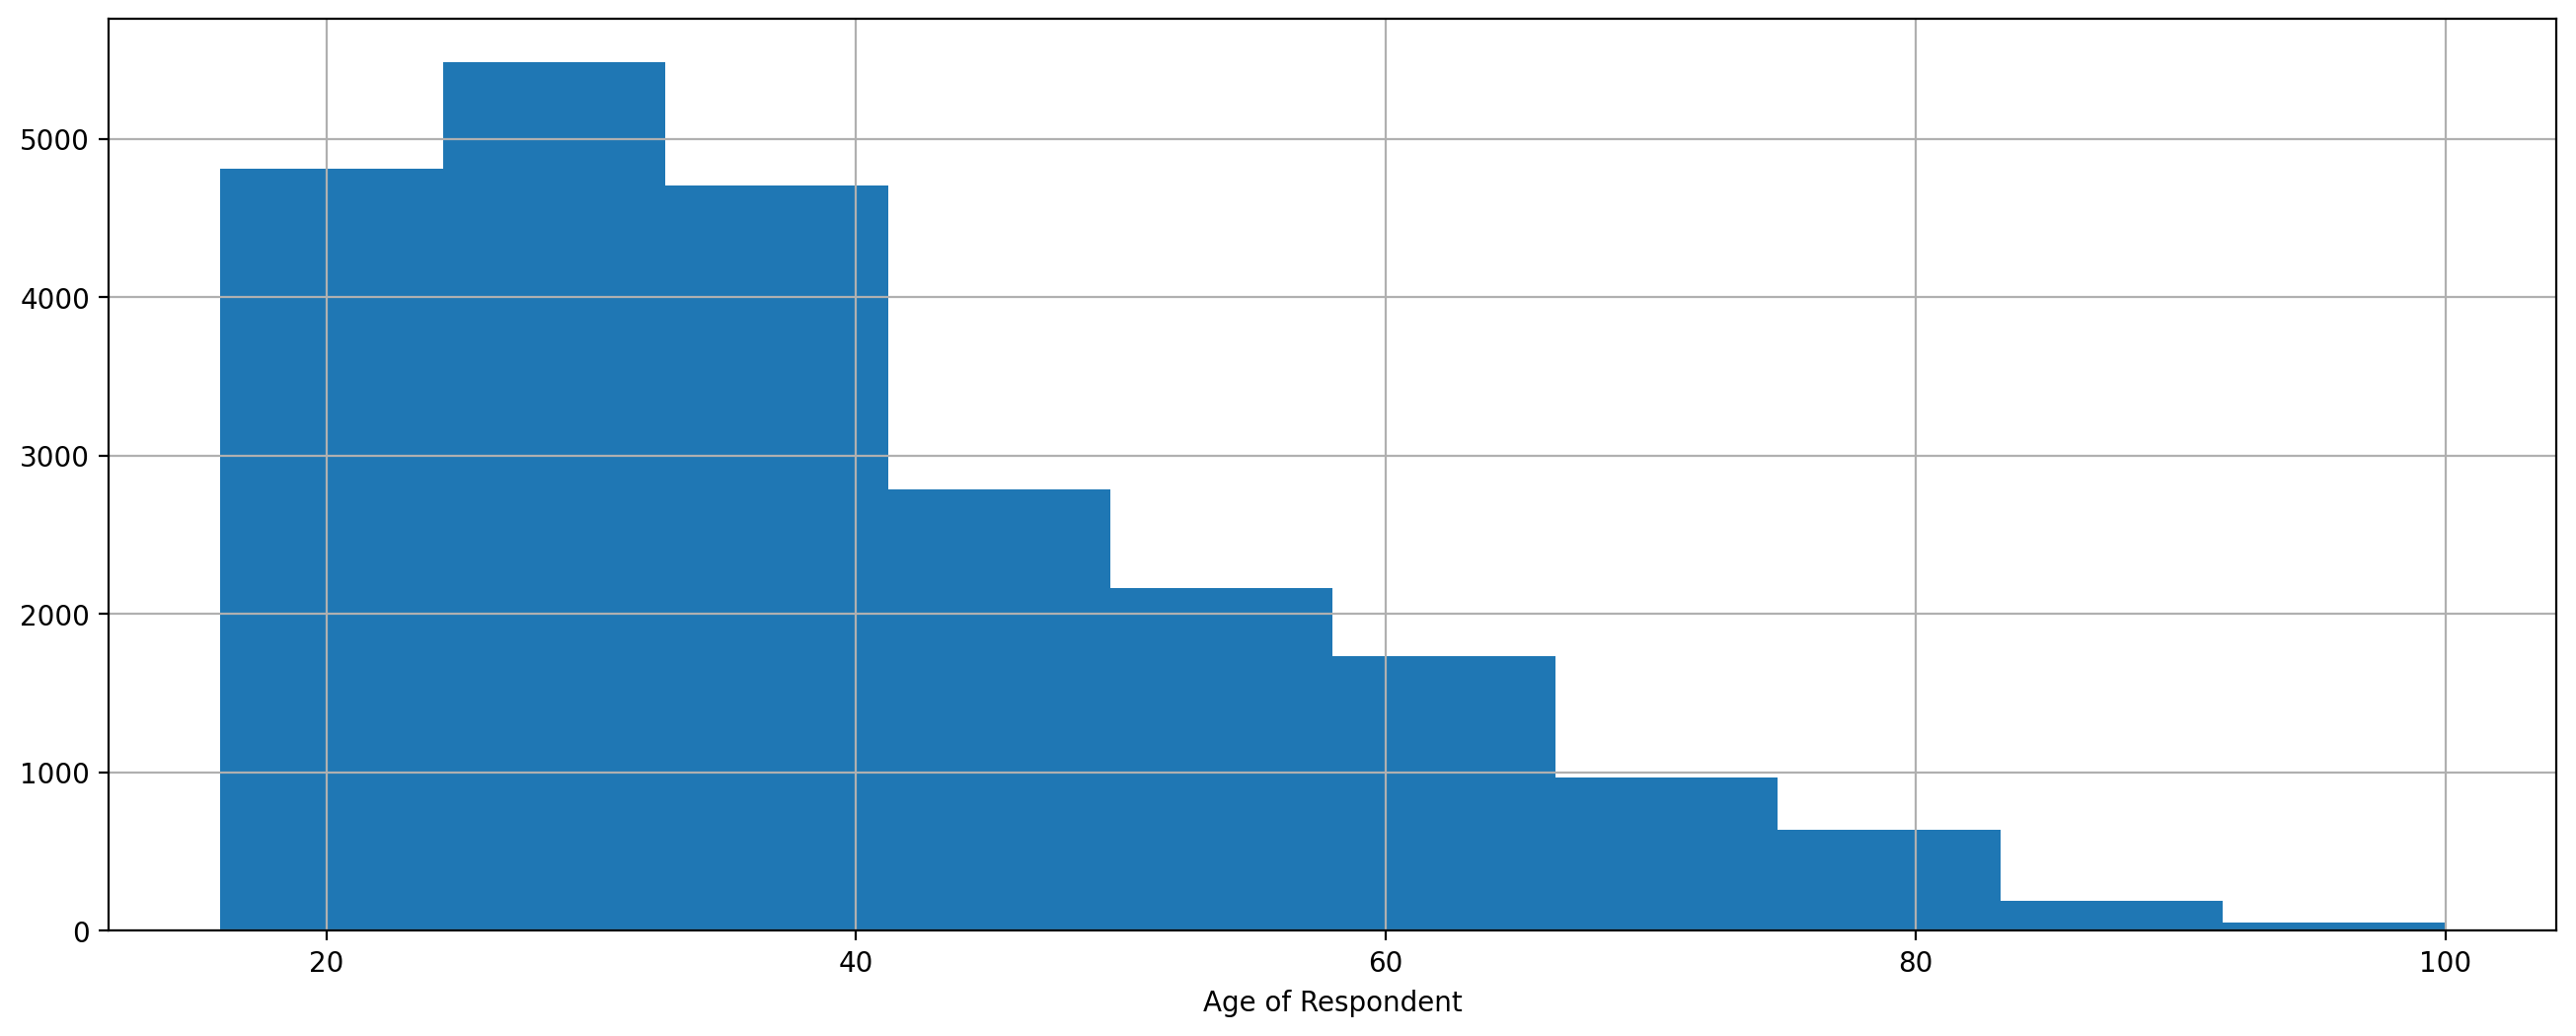

In [ ]:
# Explore household_size distribution

plt.figure(figsize=(16, 6))
data.household_size.hist()
plt.xlabel("Household  size")

# Explore age_of_respondent distribution
plt.figure(figsize=(16, 6))
data.age_of_respondent.hist()
plt.xlabel("Age of Respondent")

We learned how the features are distributed own their own. Now it can be interesting to look at how this is related to the target variable, by the __bivariate analysis__.

#### Bivariate Analysis
Bivariate analysis is the simultaneous analysis of two variables (attributes). It explores the concept of relationship between two variables, whether there exists an association and the strength of this association, or whether there are differences between two variables and the significance of these differences.

After looking at every variable individually in univariate analysis, we will now explore them again with respect to the target variable.

([0, 1, 2, 3],
 [Text(0, 0, 'Kenya'),
  Text(1, 0, 'Rwanda'),
  Text(2, 0, 'Tanzania'),
  Text(3, 0, 'Uganda')])

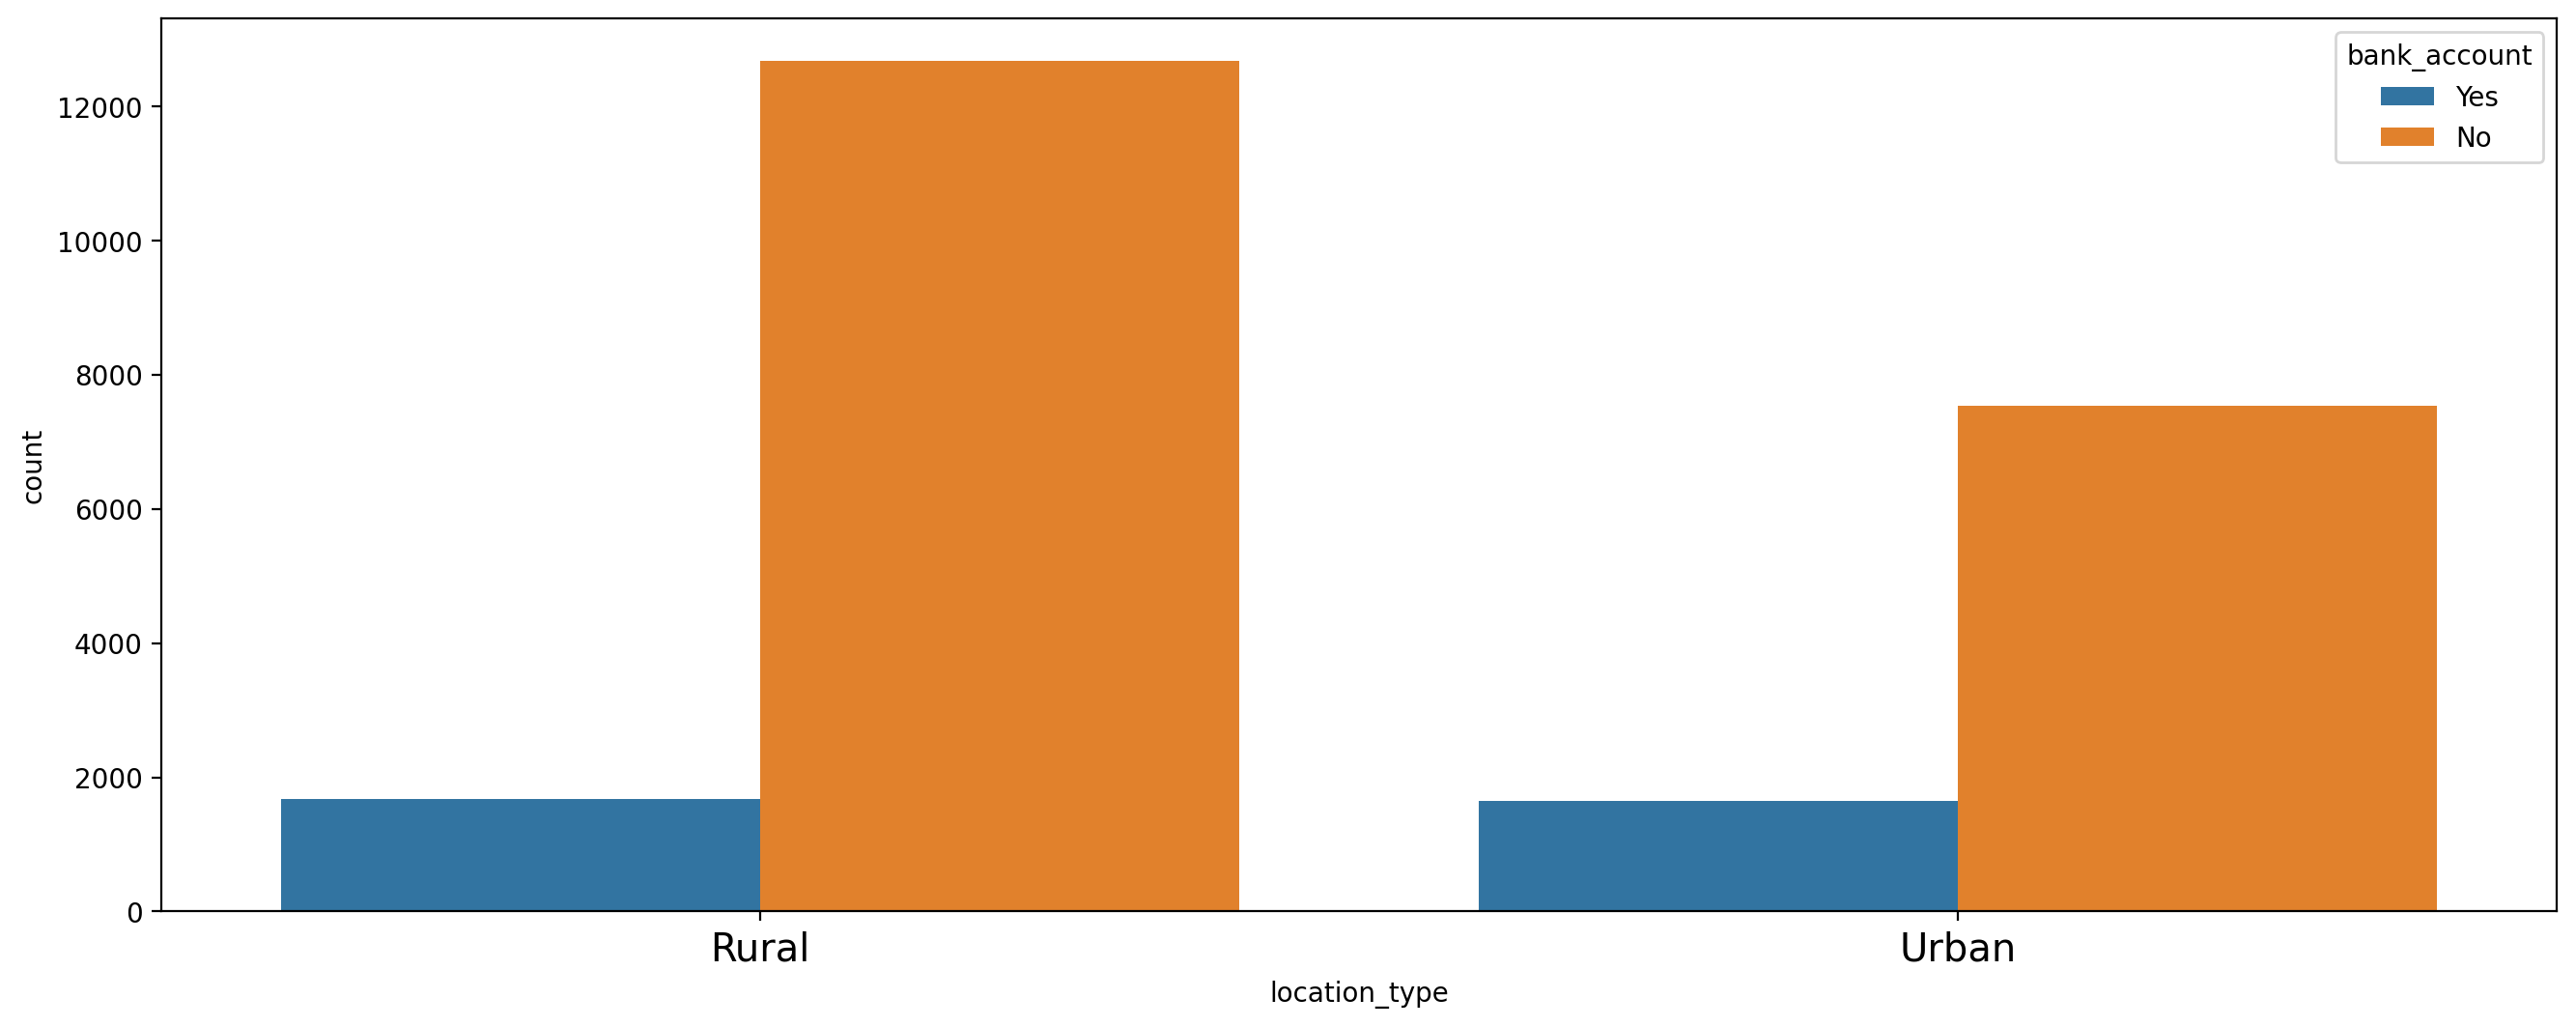

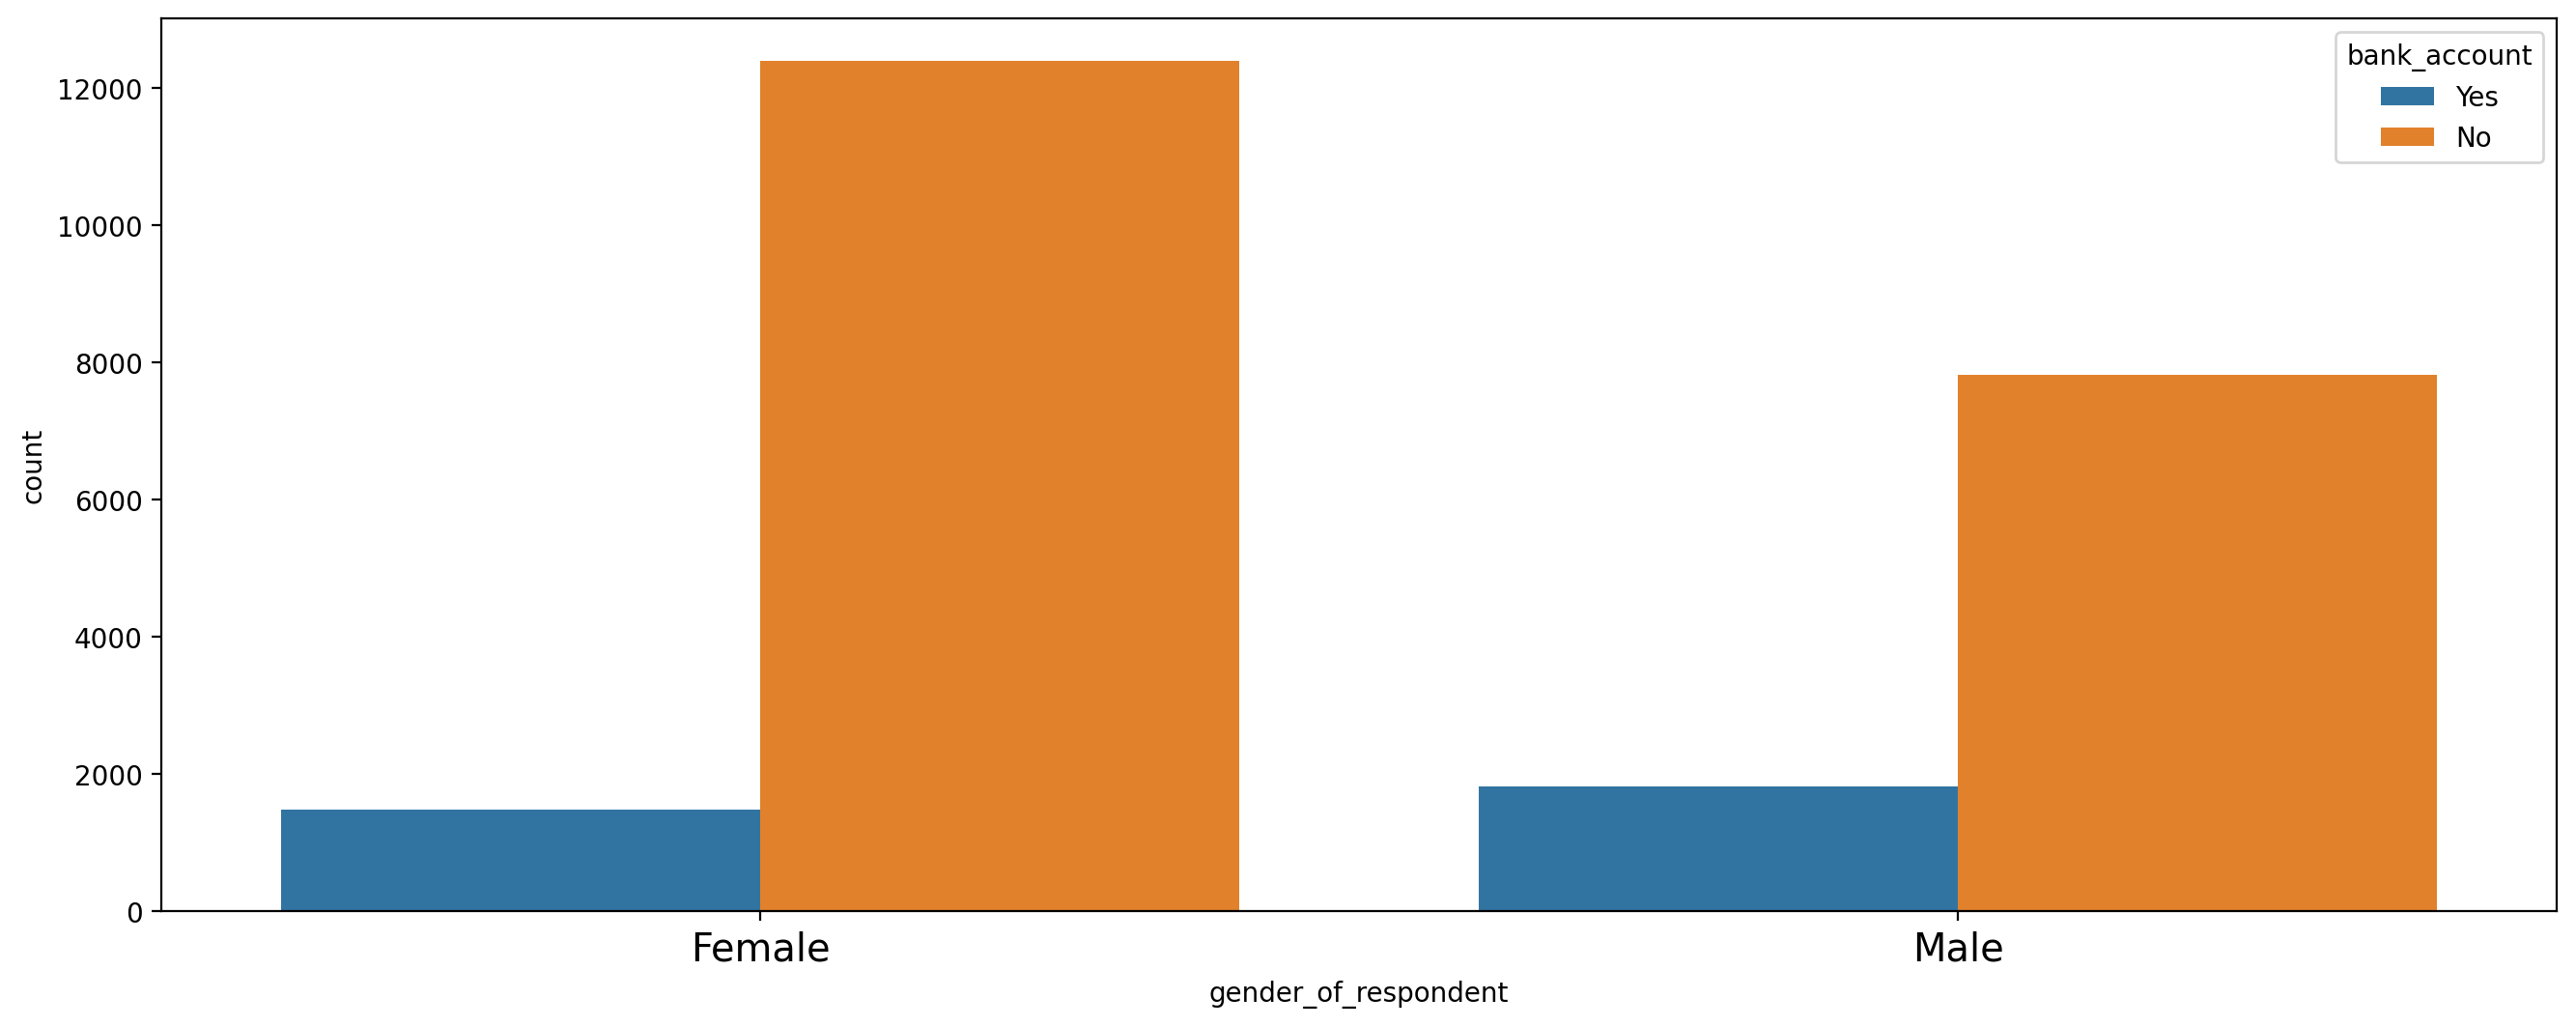

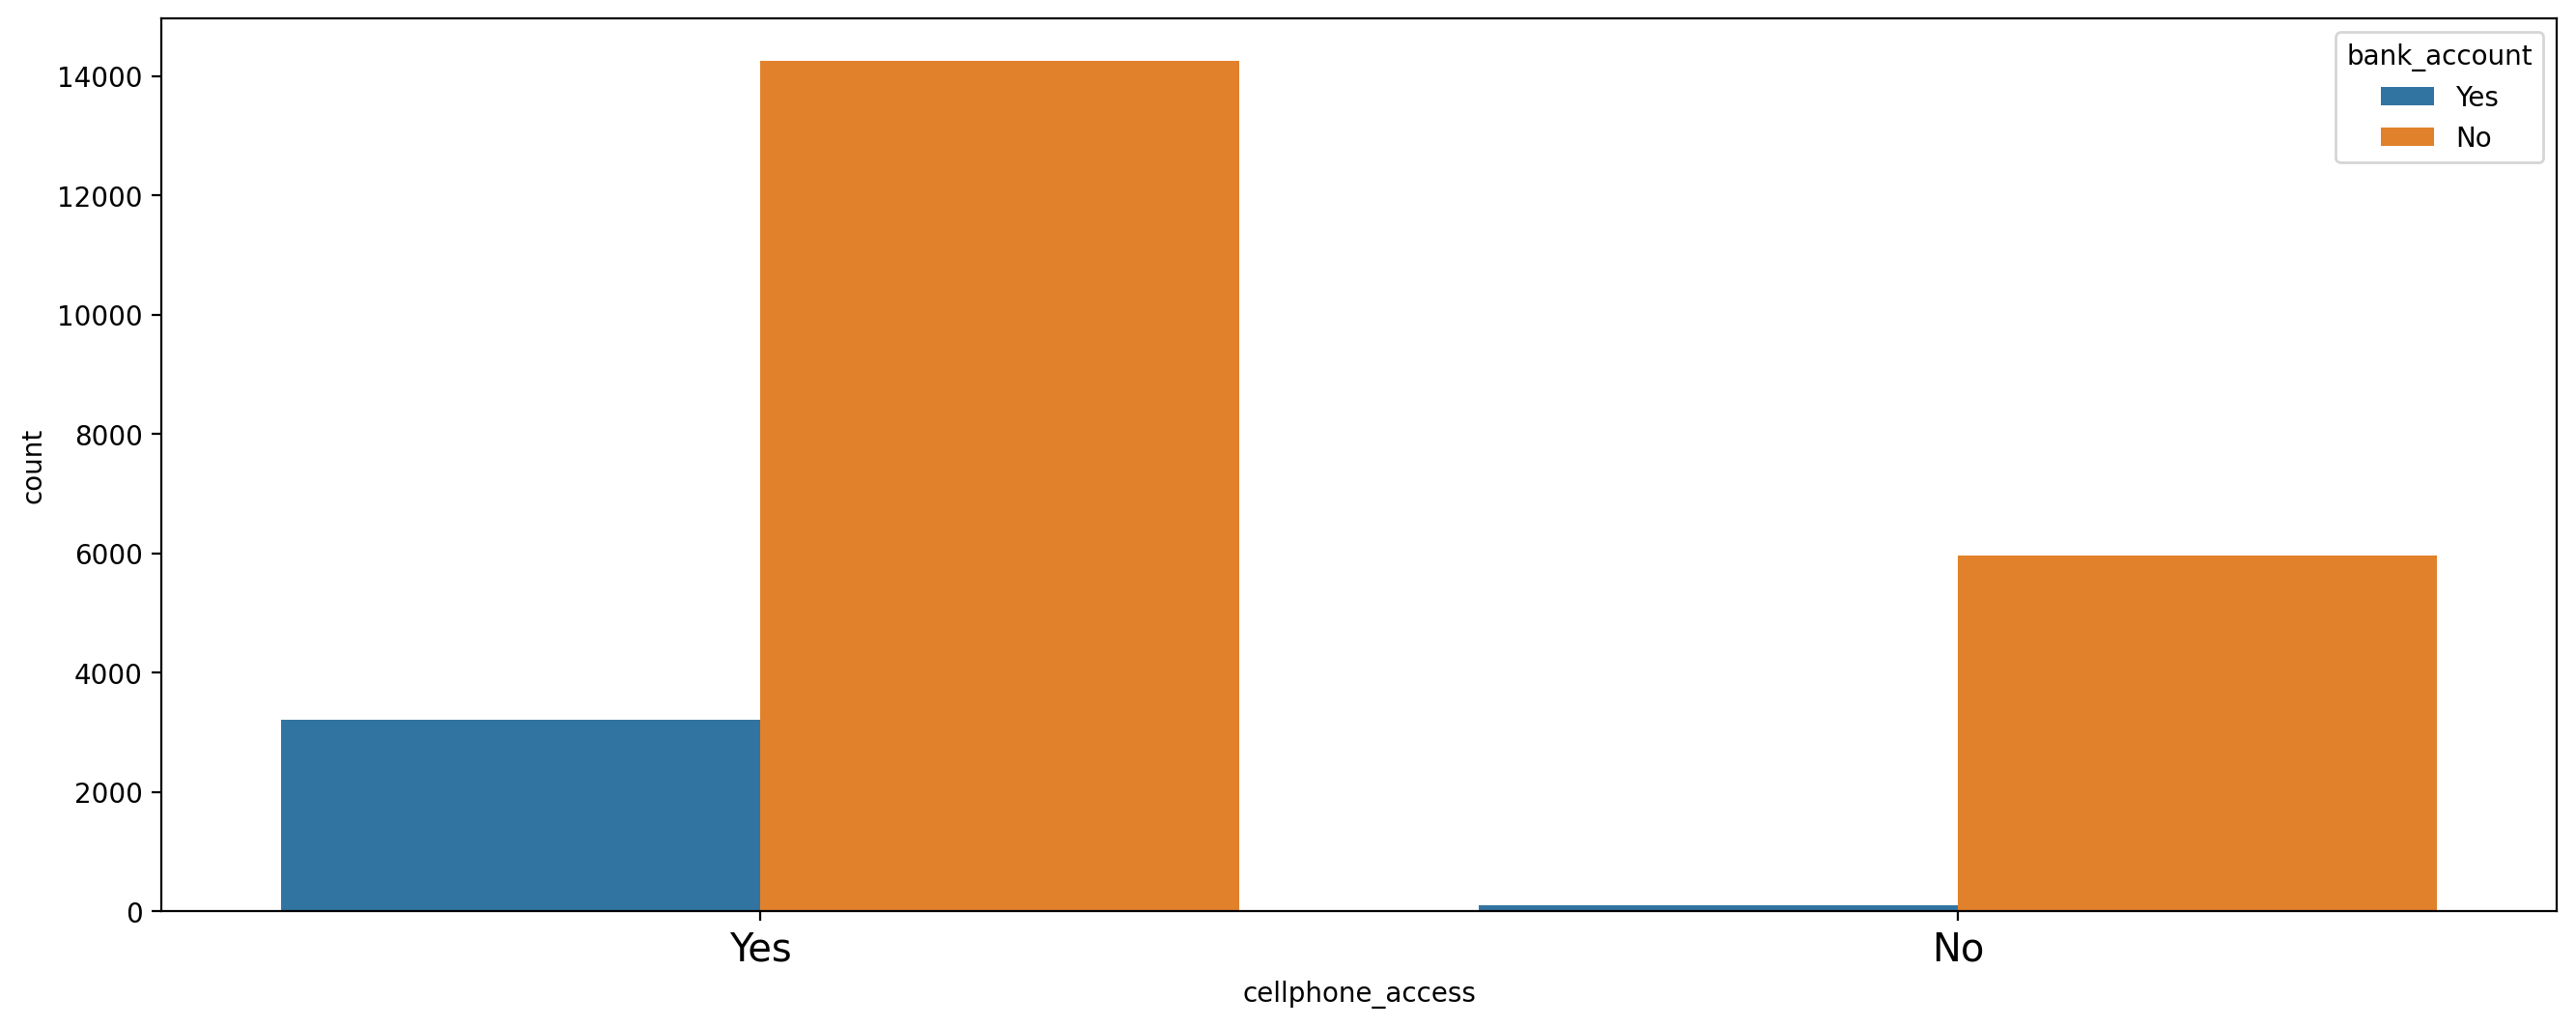

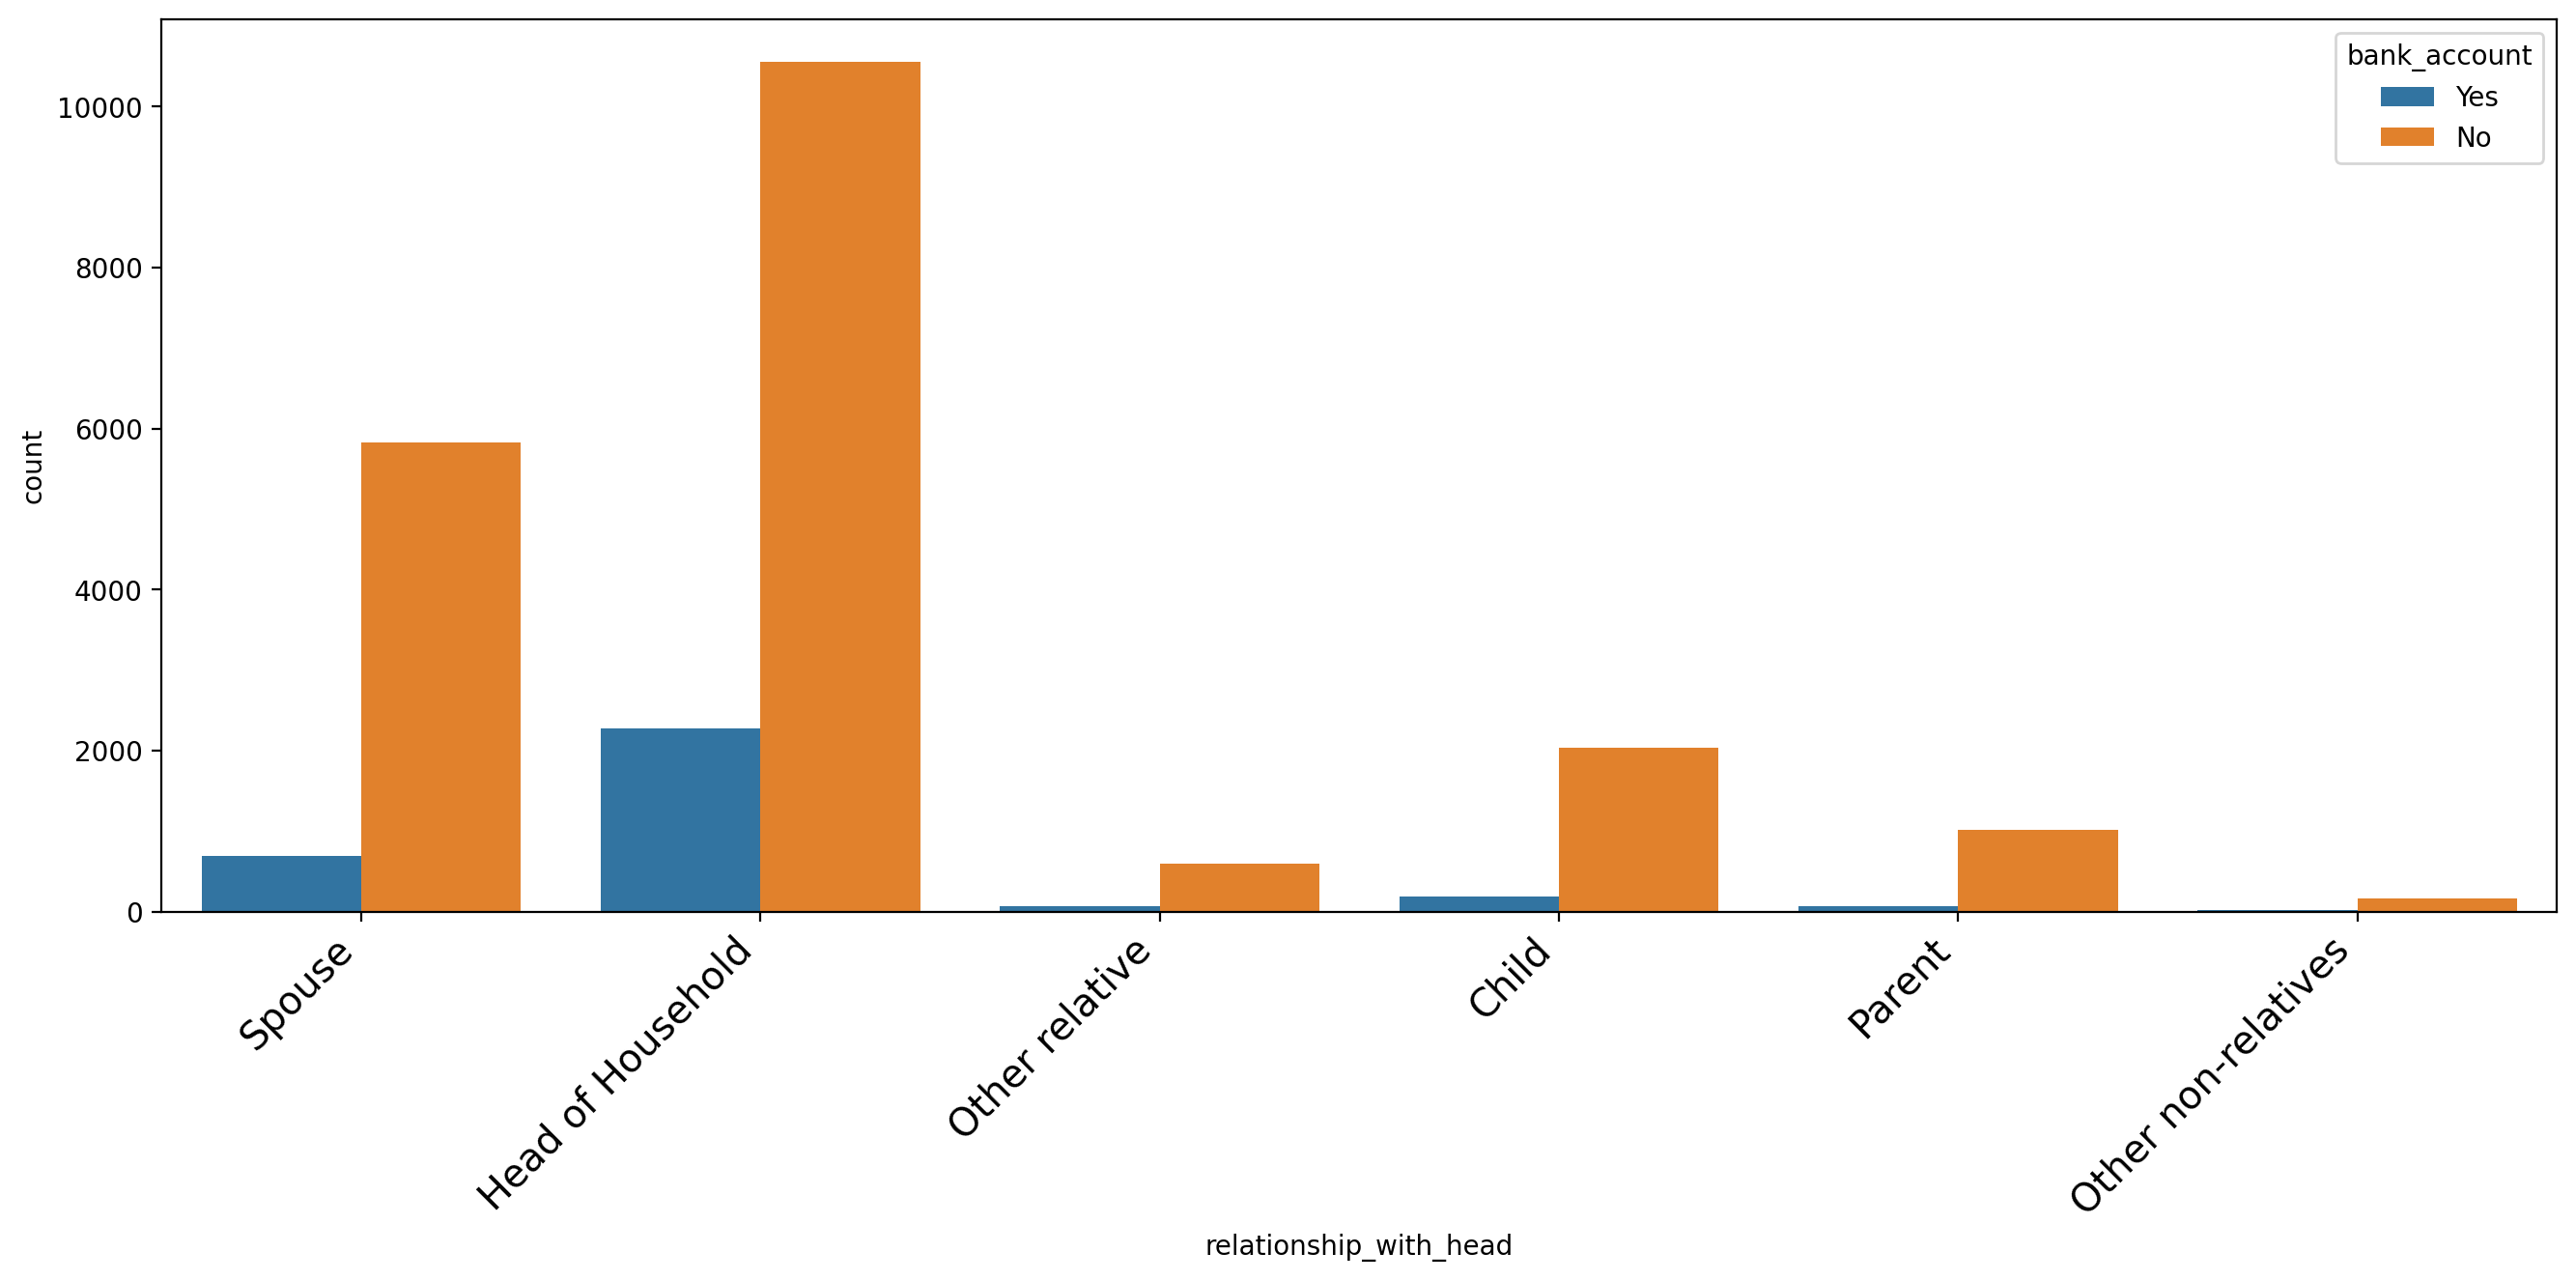

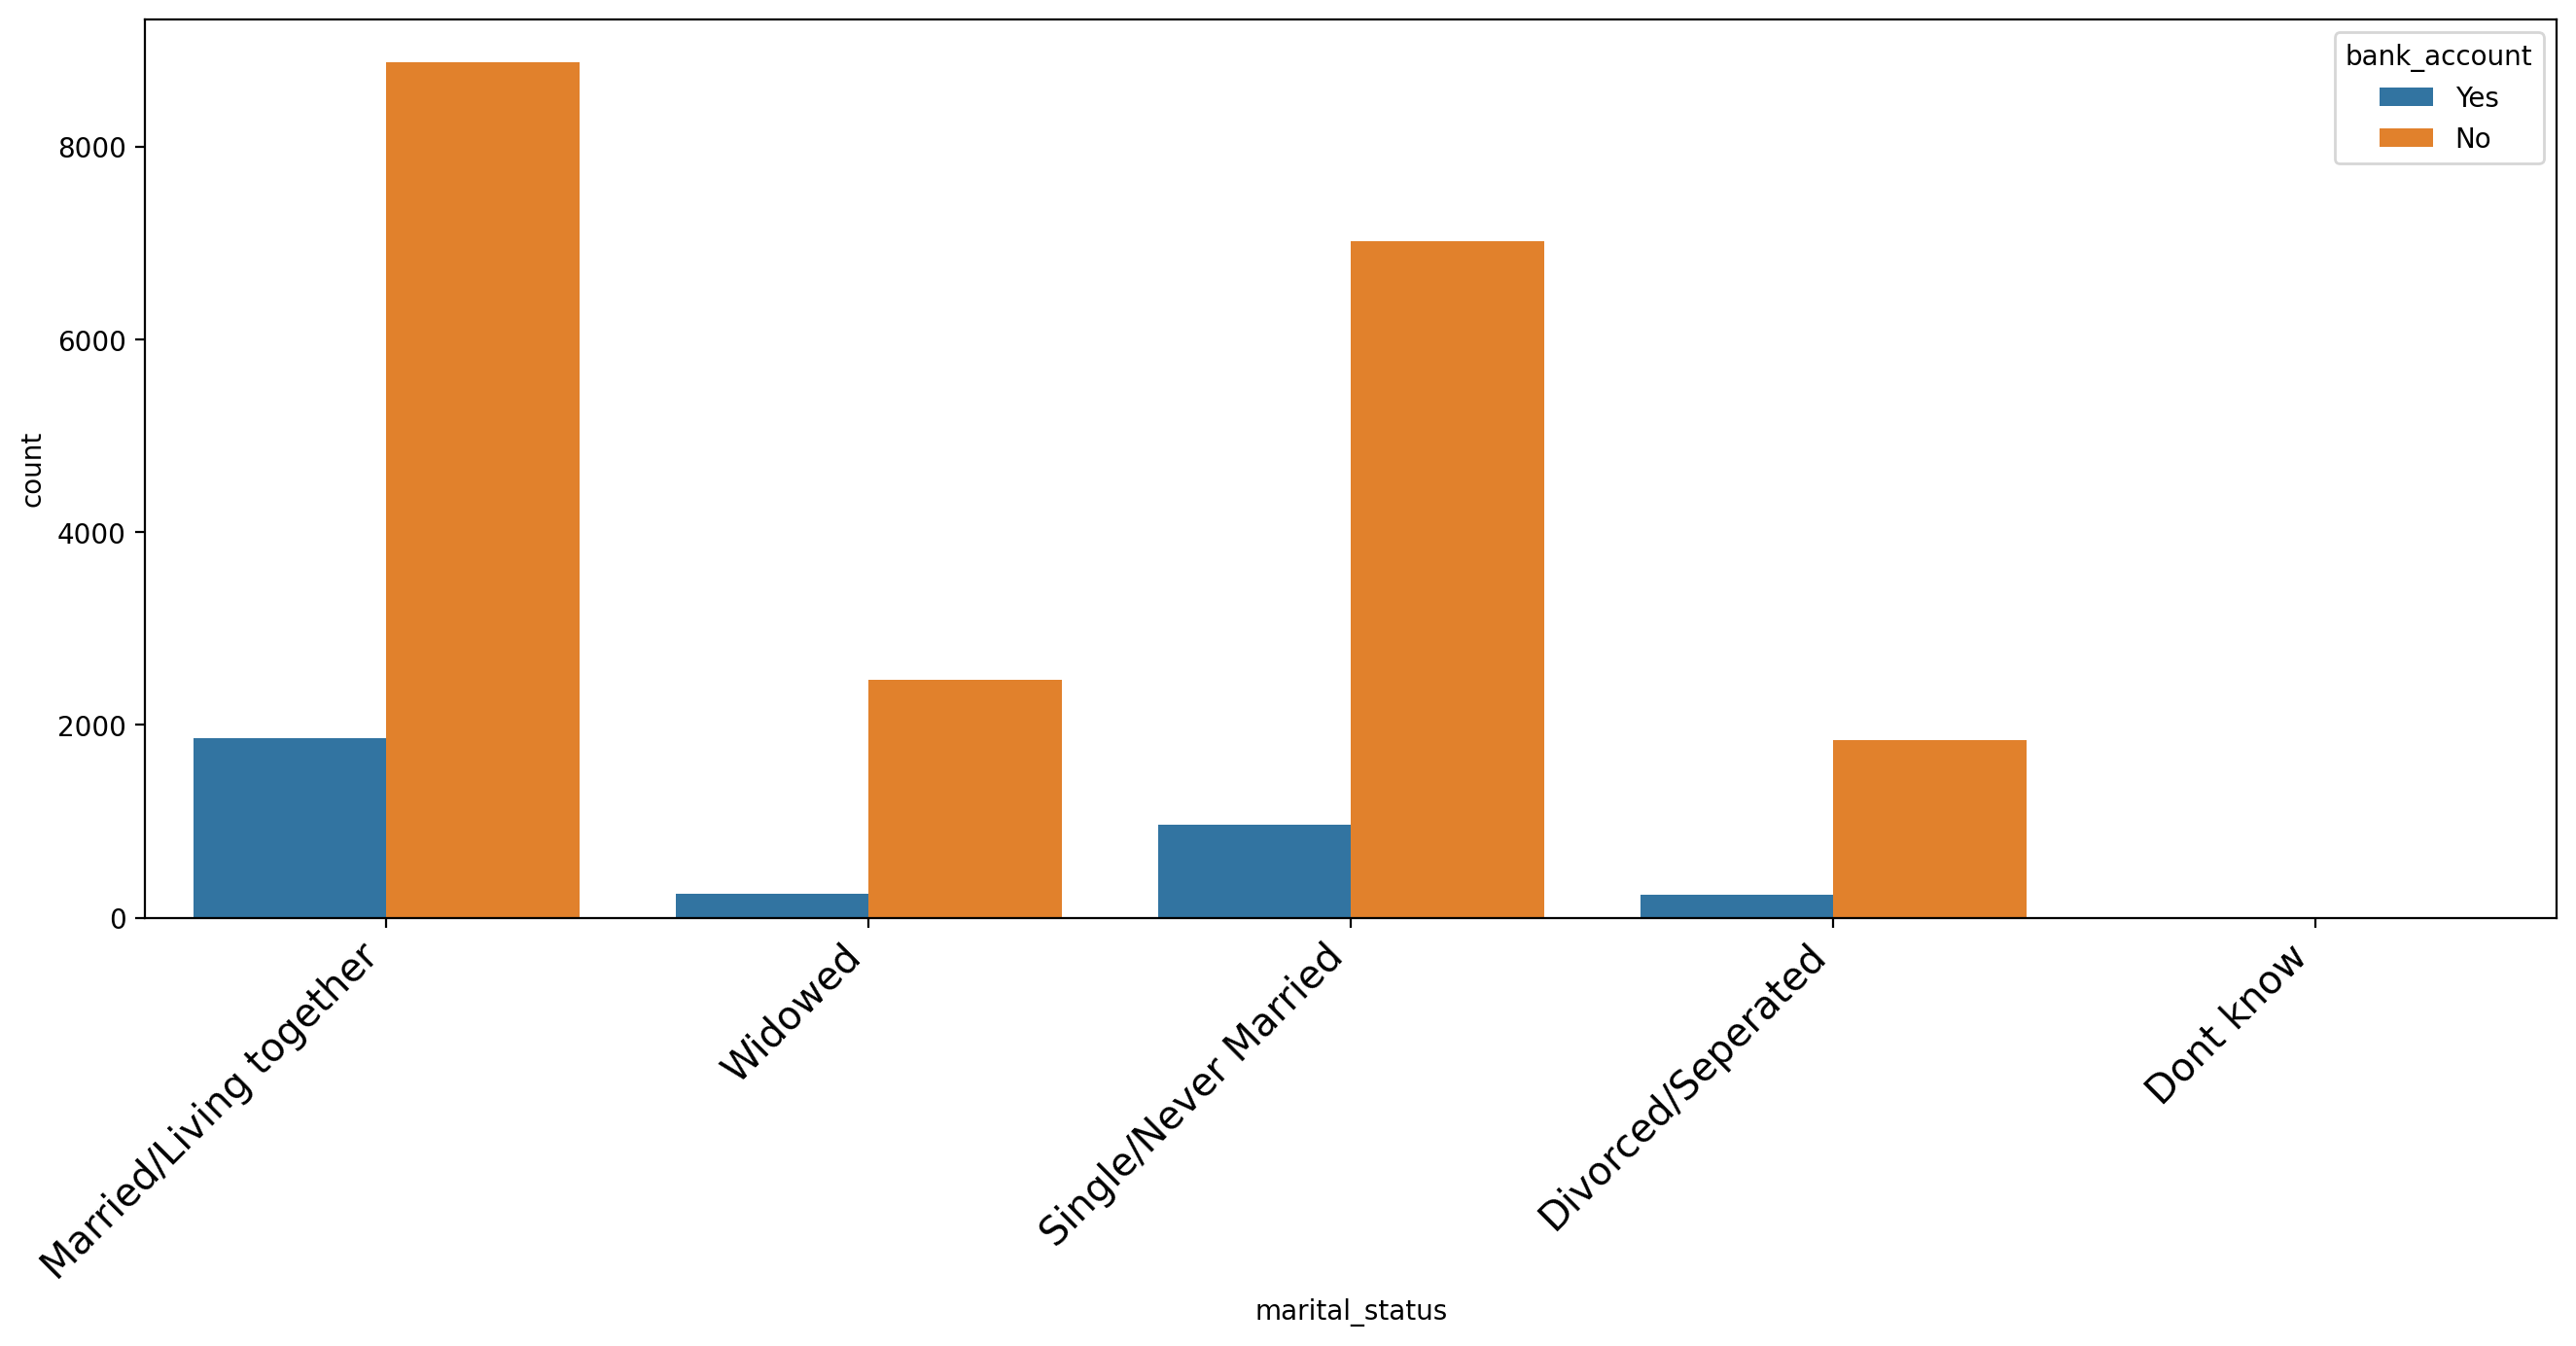

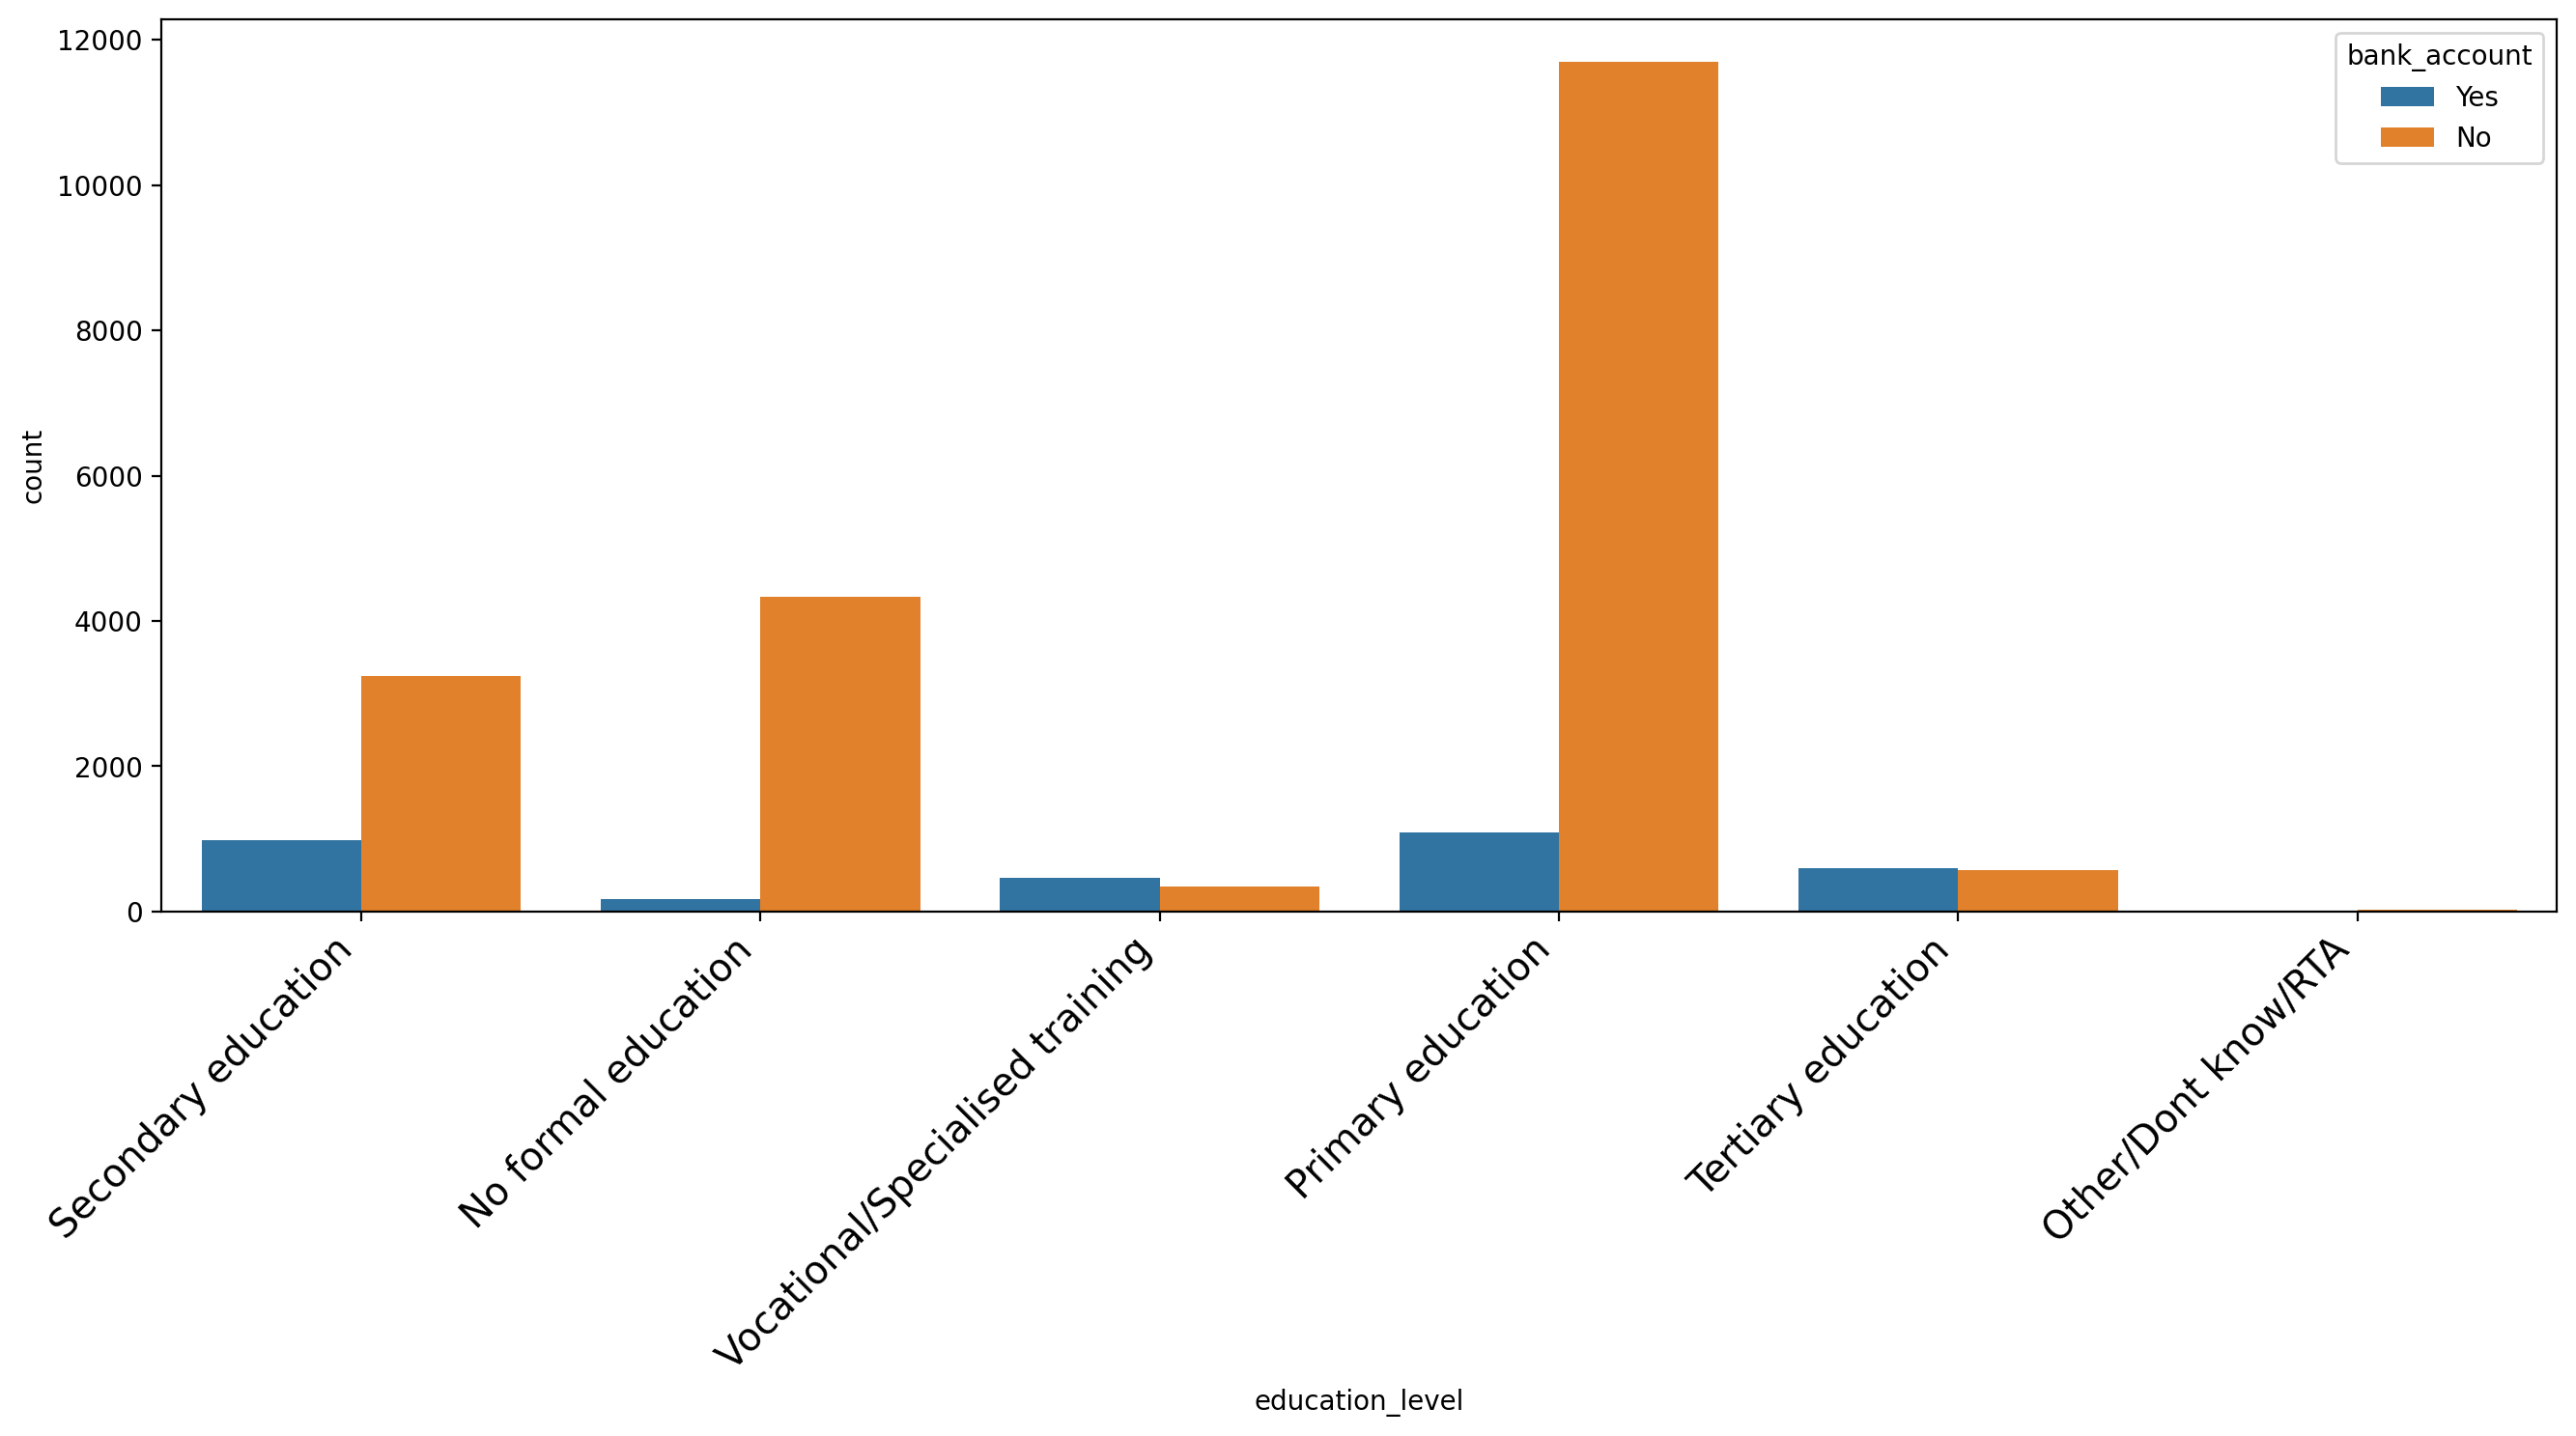

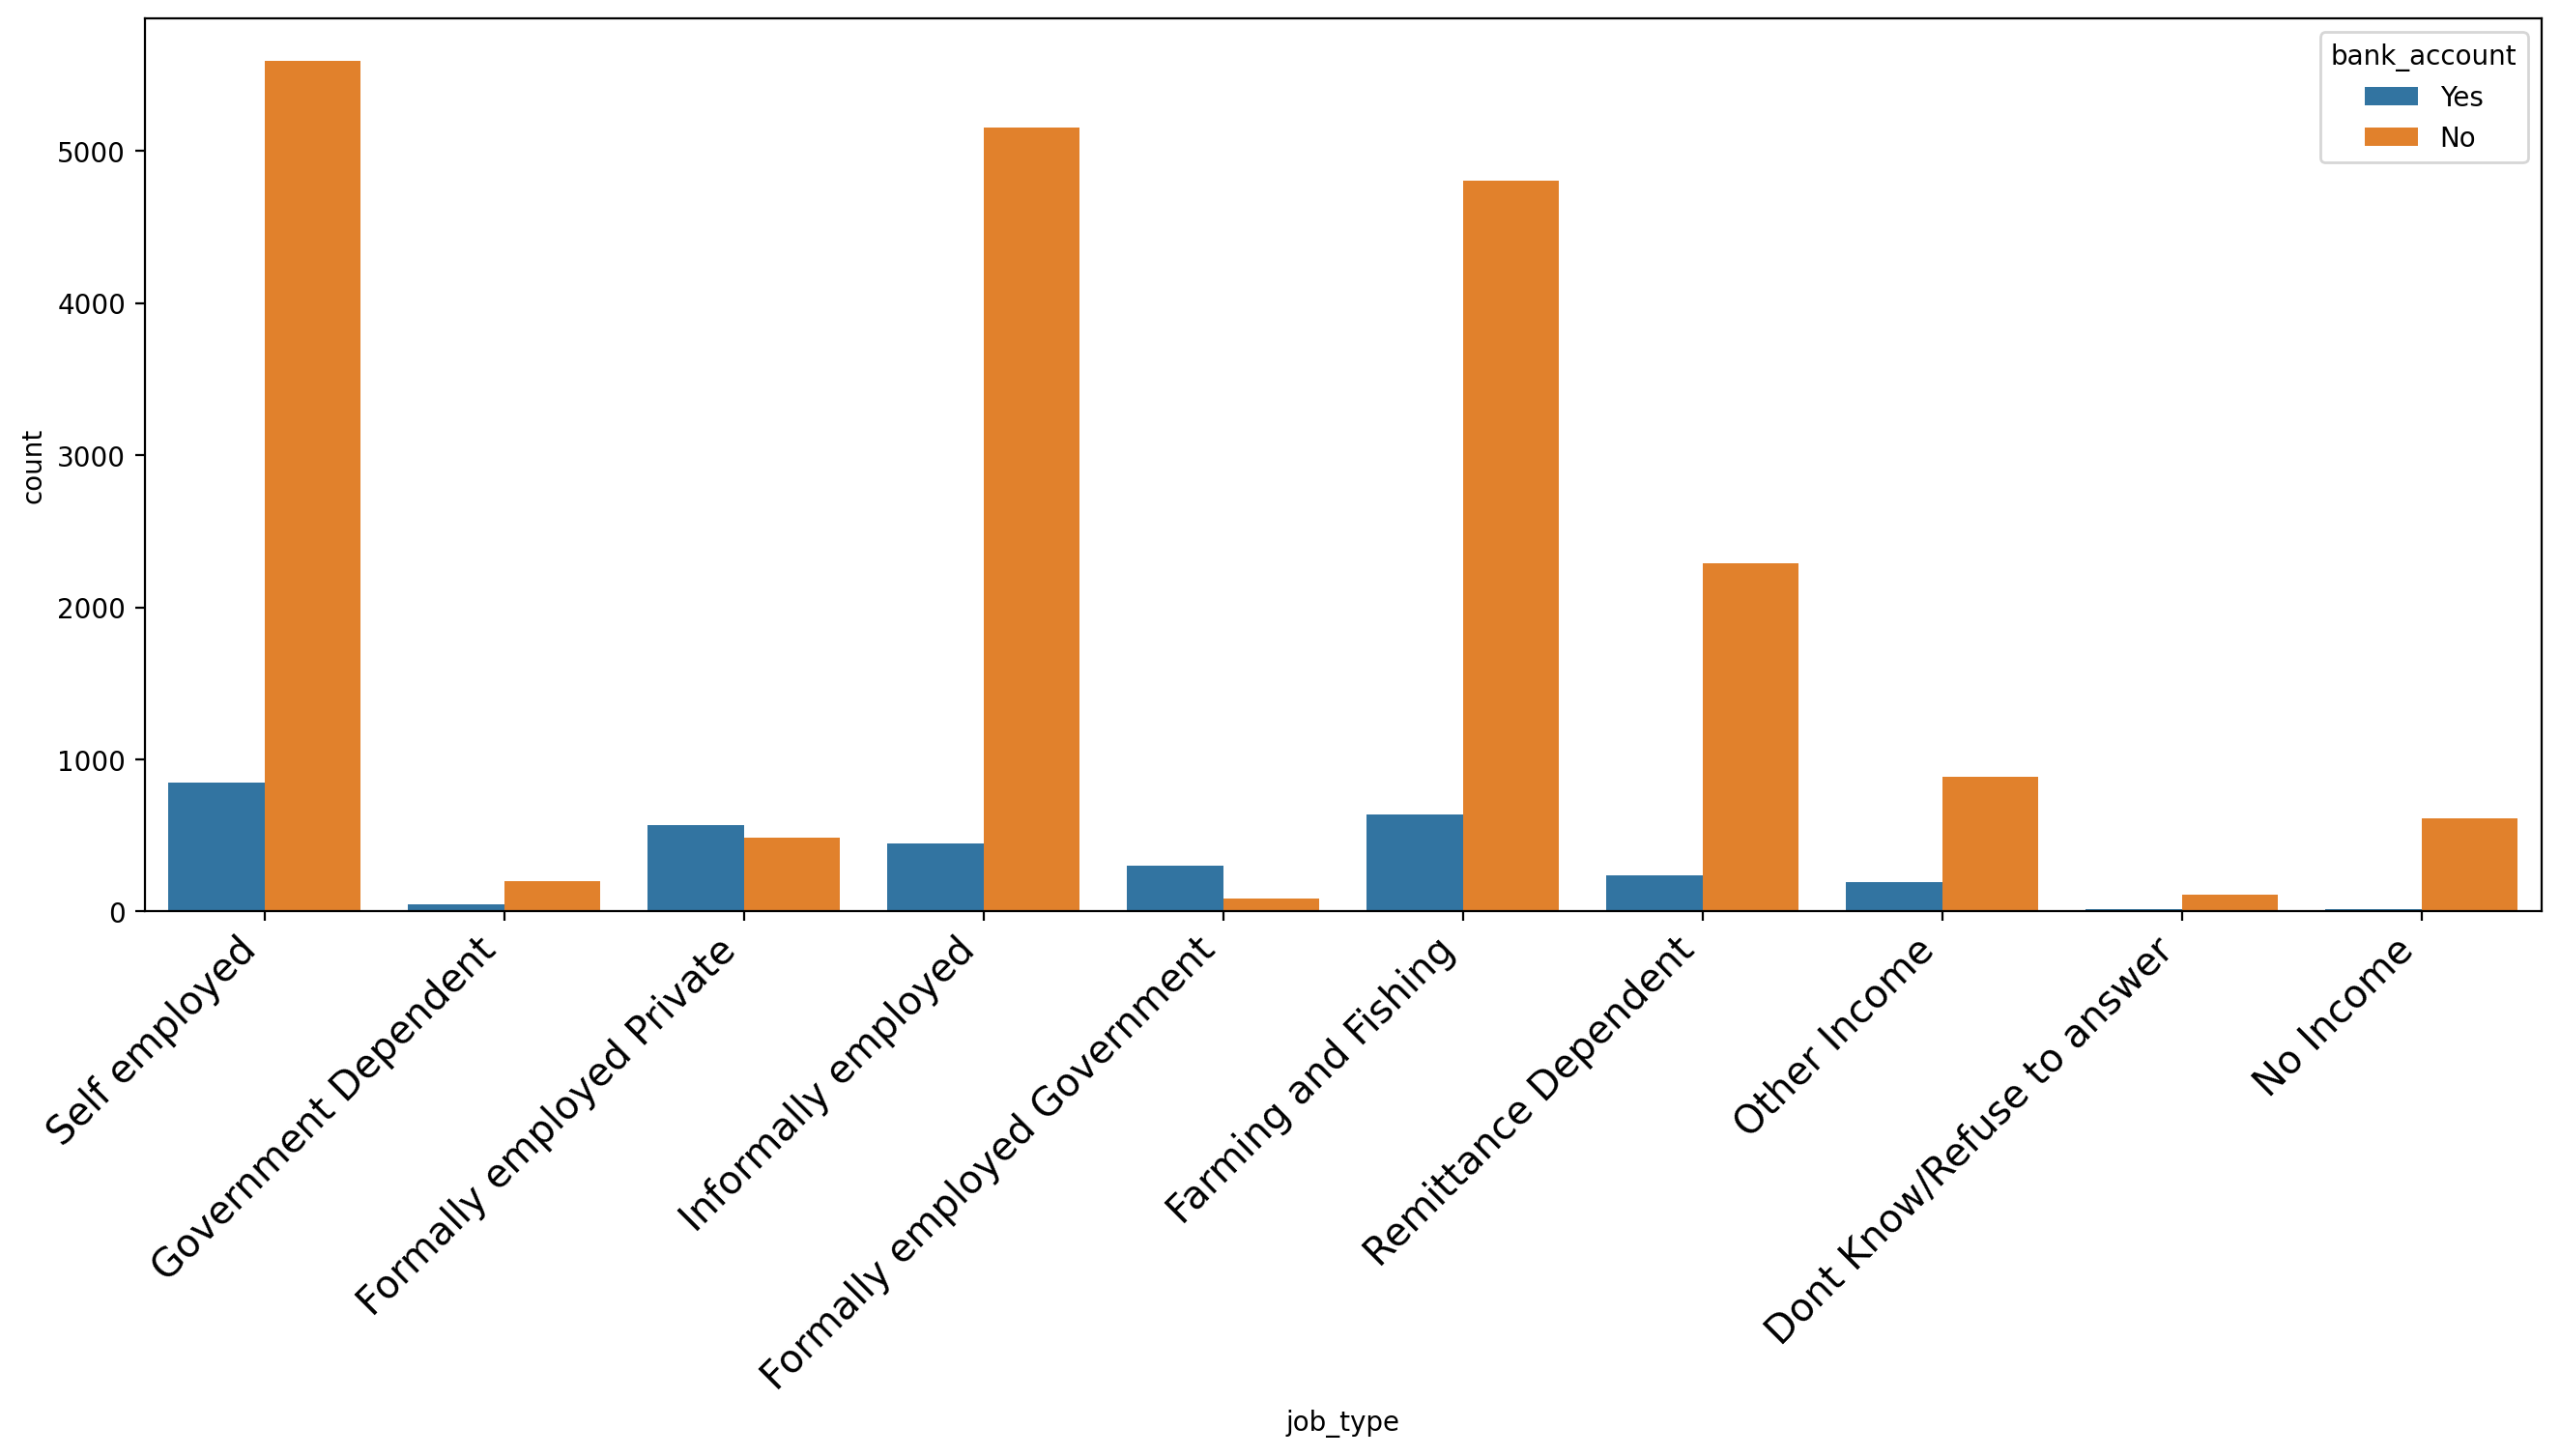

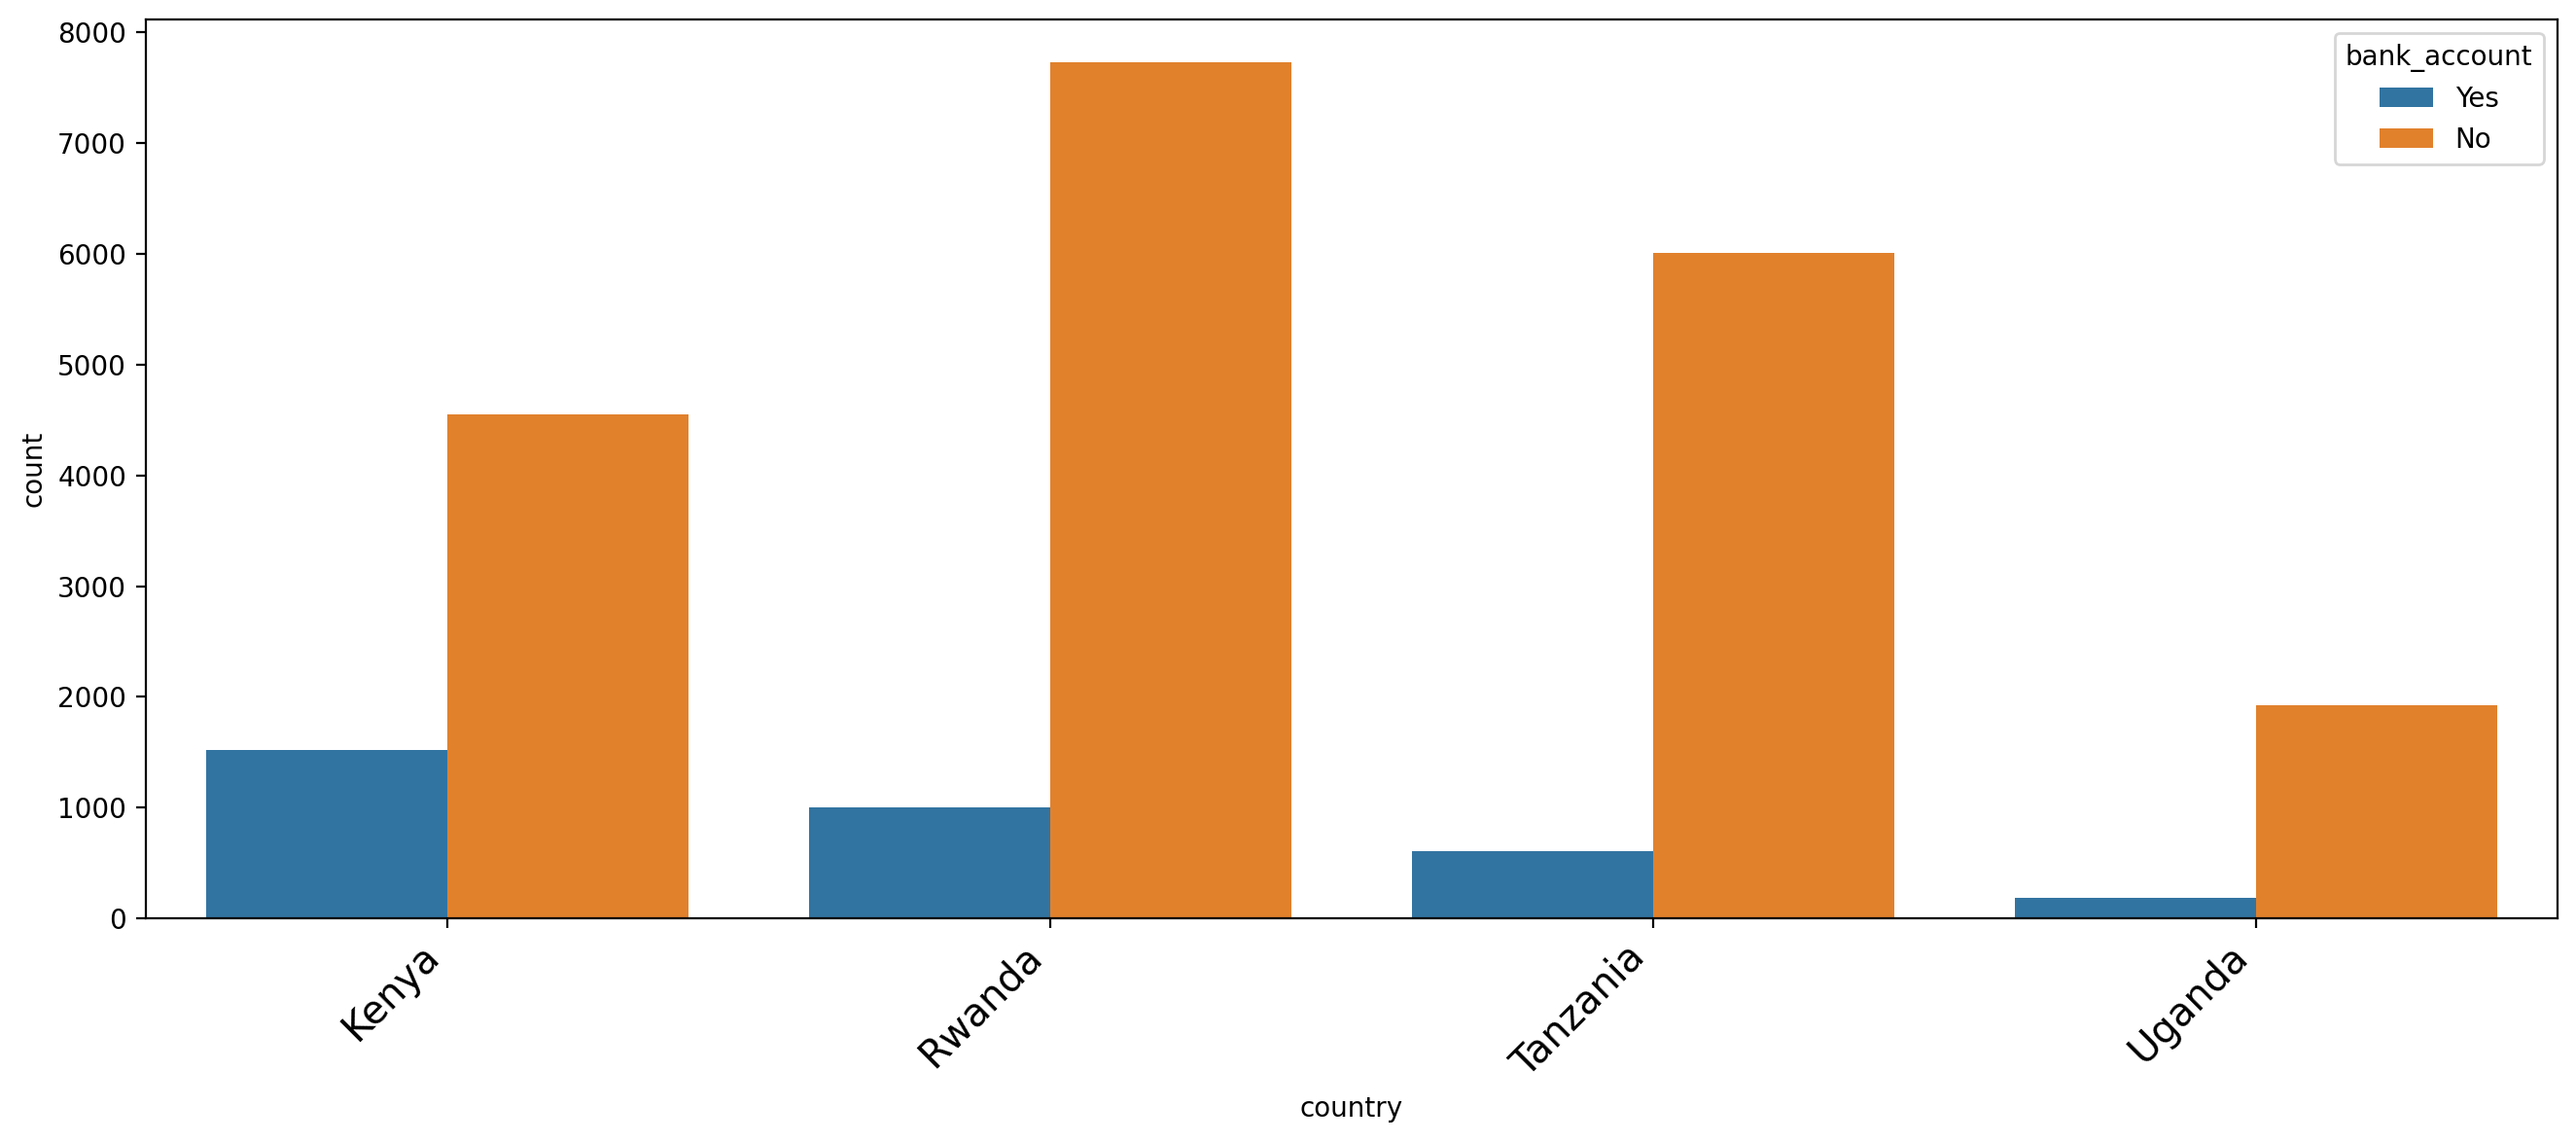

In [ ]:
# Explore location type  vs bank account

plt.figure(figsize=(16, 6))
sns.countplot(x="location_type", hue="bank_account", data=data)
plt.xticks(fontweight="light", fontsize="x-large")

# Explore gender_of_respondent vs bank account
plt.figure(figsize=(16, 6))
sns.countplot(x="gender_of_respondent", hue="bank_account", data=data)
plt.xticks(fontweight="light", fontsize="x-large")

# Explore cellphone_accesst vs bank account
plt.figure(figsize=(16, 6))
sns.countplot(x="cellphone_access", hue="bank_account", data=data)
plt.xticks(fontweight="light", fontsize="x-large")

# Explore relationship_with_head vs bank account

plt.figure(figsize=(16, 6))
sns.countplot(x="relationship_with_head", hue="bank_account", data=data)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

# Explore 'marital_status vs bank account

plt.figure(figsize=(16, 6))
sns.countplot(x="marital_status", hue="bank_account", data=data)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

# Explore 'education_level vs bank account

plt.figure(figsize=(16, 6))
sns.countplot(x="education_level", hue="bank_account", data=data)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

# Explore job_type vs bank account

plt.figure(figsize=(16, 6))
sns.countplot(x="job_type", hue="bank_account", data=data)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

# Explore country vs bank account
plt.figure(figsize=(16, 6))
sns.countplot(x="country", hue="bank_account", data=data)
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)

### Our Hypothesis Results
* People who are employed have a higher chance of having a bank account than People who are unemployed. -TRUE
* people with low education have low chance to have bank account - TRUE
* people in rural areas have low chance to have bank account -TRUE
* people who have age below 18 have low chance to have bank account-TRUE
* female have less chance to have bank account -TRUE

## Feature Engineering

Here we want to apply the knowledge we acquired during the data analysis to perform the most suitable feature engineering to our problem.

In [ ]:
data = data.drop("uniqueid", axis=1)  # no need of uniqueid

In [ ]:
# First: train-test split
X = data.drop("bank_account", axis=1)
y = data["bank_account"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, input_array, y=None):
        return self

    def transform(self, input_array, y=None):
        return input_array

We have seen there is no null values, so we only need to deal with encoding the data and scaling eventually.

In [ ]:
for i, col in enumerate(X.columns):
    print(i, col)

0 country
1 year
2 location_type
3 cellphone_access
4 household_size
5 age_of_respondent
6 gender_of_respondent
7 relationship_with_head
8 marital_status
9 education_level
10 job_type


In [ ]:
# Preprocessing base
base_preprocessing = ColumnTransformer(
    transformers=[
        ("ohe_country", OneHotEncoder(drop="first", sparse_output=False), [0]),
        ("ord_year", OrdinalEncoder(), [1]),
        ("ohe_location_cell", OneHotEncoder(drop="first", sparse_output=False), [2, 3]),
        ("do_nothing", IdentityTransformer(), [4, 5]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), [6, 7, 8, 9, 10]),
    ],
)

base_pipe = Pipeline(
    [("preprocess", base_preprocessing), ("model", LogisticRegression())]
)

In [ ]:
base_pipe.fit(X_train, y_train)

y_pred = base_pipe.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          No       0.97      0.90      0.93      4383
         Yes       0.32      0.66      0.43       322

    accuracy                           0.88      4705
   macro avg       0.65      0.78      0.68      4705
weighted avg       0.93      0.88      0.90      4705



Let's try to apply some scaling to the numerical features to see whether this improves the performances, even if we can clearly see that the class unbalance is the main issue here.

In [ ]:
scaled_preprocessing = ColumnTransformer(
    transformers=[
        ("ohe_country", OneHotEncoder(drop="first", sparse_output=False), [0]),
        ("ord_year", OrdinalEncoder(), [1]),
        ("ohe_location_cell", OneHotEncoder(drop="first", sparse_output=False), [2, 3]),
        ("scale", StandardScaler(), [4, 5]),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False), [6, 7, 8, 9, 10]),
    ],
)

In [ ]:
scaled_pipe = Pipeline(
    [("preprocess", scaled_preprocessing), ("model", LogisticRegression())]
)

scaled_pipe.fit(X_train, y_train)

y_pred = scaled_pipe.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          No       0.97      0.90      0.93      4374
         Yes       0.34      0.67      0.45       331

    accuracy                           0.88      4705
   macro avg       0.65      0.79      0.69      4705
weighted avg       0.93      0.88      0.90      4705



## More complex models
We are going to try with unbalanced data, RandomForest and XGBoost before passing to operate on data class balance.

### RandomForest

In [ ]:
rf_pipe = Pipeline(
    [("preprocess", scaled_preprocessing), ("model", RandomForestClassifier())]
)

rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          No       0.94      0.90      0.92      4215
         Yes       0.39      0.52      0.44       490

    accuracy                           0.86      4705
   macro avg       0.66      0.71      0.68      4705
weighted avg       0.88      0.86      0.87      4705



### XGBoost

In [ ]:
y_train.replace({"No": 0, "Yes": 1})

2465     0
14096    0
2138     0
5108     0
5198     0
        ..
8282     0
20357    0
19688    0
18329    0
6719     0
Name: bank_account, Length: 18819, dtype: int64

In [ ]:
xgb_pipe = Pipeline(
    [("preprocess", scaled_preprocessing), ("model", xgb.XGBClassifier())]
)

xgb_pipe.fit(X_train, y_train.replace({"No": 0, "Yes": 1}))

y_pred = xgb_pipe.predict(X_test)
print(classification_report(y_pred, y_test.replace({"No": 0, "Yes": 1})))

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      4329
           1       0.38      0.66      0.48       376

    accuracy                           0.89      4705
   macro avg       0.67      0.78      0.71      4705
weighted avg       0.92      0.89      0.90      4705



No great improvement, we need to operate on the data unbalance.

In [ ]:
smote = SMOTE(random_state=42)
X_train_preprocessed = scaled_preprocessing.fit_transform(X_train)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train)

# Check the new class distribution
print("Original class distribution:")
print(y_train.value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())

Original class distribution:
bank_account
No     16169
Yes     2650
Name: count, dtype: int64

Balanced class distribution:
bank_account
No     16169
Yes    16169
Name: count, dtype: int64


In [ ]:
rf_model_smote = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
)

rf_model_smote.fit(X_train_balanced, y_train_balanced)

# Make predictions on test set
X_test_transformed = scaled_preprocessing.transform(X_test)
y_pred_rf = rf_model_smote.predict(X_test_transformed)

# Print classification report
print("Random Forest Classification Report with SMOTE:")
print(classification_report(y_test, y_pred_rf))

# Optional: Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report with SMOTE:
              precision    recall  f1-score   support

          No       0.94      0.83      0.88      4043
         Yes       0.40      0.69      0.51       662

    accuracy                           0.81      4705
   macro avg       0.67      0.76      0.70      4705
weighted avg       0.87      0.81      0.83      4705


Confusion Matrix:
[[3367  676]
 [ 203  459]]


### XGBOOST

In [ ]:
# Train XGBoost on SMOTE-balanced data
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

# Convert labels to numeric for XGBoost
y_train_balanced_numeric = pd.Series(y_train_balanced).replace({"No": 0, "Yes": 1})

# Train the model
xgb_model.fit(X_train_balanced, y_train_balanced_numeric)

# make predictions
y_pred_xgb = xgb_model.predict(X_test_transformed)

# Print classification report
print("XGBoost Classification Report with SMOTE:")
print(classification_report(y_test.replace({"No": 0, "Yes": 1}), y_pred_xgb))

# Optional: Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test.replace({"No": 0, "Yes": 1}), y_pred_xgb))

XGBoost Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4043
           1       0.49      0.58      0.53       662

    accuracy                           0.86      4705
   macro avg       0.71      0.74      0.72      4705
weighted avg       0.87      0.86      0.86      4705


Confusion Matrix:
[[3647  396]
 [ 278  384]]


### XGBOOST with class weights

In [ ]:
# Calculate class weights
class_counts = y_train.replace({"No": 0, "Yes": 1}).value_counts()
total_samples = len(y_train)
class_weights = {
    0: 0.5,  # weight for majority class
    1: 2,  # weight for minority class
}

# Train XGBoost with class weights
xgb_weighted = Pipeline(
    [
        ("preprocess", scaled_preprocessing),
        (
            "model",
            xgb.XGBClassifier(
                scale_pos_weight=class_weights[1]
                / class_weights[0],  # ratio of weights
                n_estimators=100,
                learning_rate=0.1,
                max_depth=5,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
            ),
        ),
    ]
)

# Fit and evaluate
xgb_weighted.fit(X_train, y_train.replace({"No": 0, "Yes": 1}))

y_pred_weighted = xgb_weighted.predict(X_test)

# Print results
print("XGBoost Classification Report with Class Weights:")
print(classification_report(y_test.replace({"No": 0, "Yes": 1}), y_pred_weighted))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test.replace({"No": 0, "Yes": 1}), y_pred_weighted))

XGBoost Classification Report with Class Weights:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      4043
           1       0.45      0.64      0.53       662

    accuracy                           0.84      4705
   macro avg       0.69      0.76      0.72      4705
weighted avg       0.87      0.84      0.85      4705


Confusion Matrix:
[[3528  515]
 [ 237  425]]


In [ ]:
# Calculate class weights
class_counts = y_train.value_counts()
total_samples = len(y_train)
class_weights = {
    "No": 0.5,  # weight for majority class
    "Yes": 2,  # weight for minority class
}

# Train Random Forest with class weights
rf_weighted = Pipeline(
    [
        ("preprocess", scaled_preprocessing),
        (
            "model",
            RandomForestClassifier(
                class_weight=class_weights,
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                min_samples_leaf=2,
                random_state=42,
            ),
        ),
    ]
)

# Fit and evaluate
rf_weighted.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ohe_country',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [0]),
                                                 ('ord_year', OrdinalEncoder(),
                                                  [1]),
                                                 ('ohe_location_cell',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [2, 3]),
                                                 ('scale', StandardScaler(),
                                                  [4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  [6, 7, 8, 9, 10])])),
                ('model',
                 RandomForestClassifier(class_weight={'No': 0.5, 'Yes': 2},
                                        max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5,
                                        random_state=42))])

In [ ]:
# Print results
y_pred = rf_weighted.predict(X_test)
print("RF Classification Report with Class Weights:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RF Classification Report with Class Weights:
              precision    recall  f1-score   support

          No       0.93      0.90      0.92      4043
         Yes       0.49      0.59      0.54       662

    accuracy                           0.86      4705
   macro avg       0.71      0.75      0.73      4705
weighted avg       0.87      0.86      0.86      4705


Confusion Matrix:
[[3642  401]
 [ 270  392]]


Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4043
           1       0.23      0.23      0.23       662

    accuracy                           0.78      4705
   macro avg       0.55      0.55      0.55      4705
weighted avg       0.78      0.78      0.78      4705


Confusion Matrix:
[[3534  509]
 [ 509  153]]


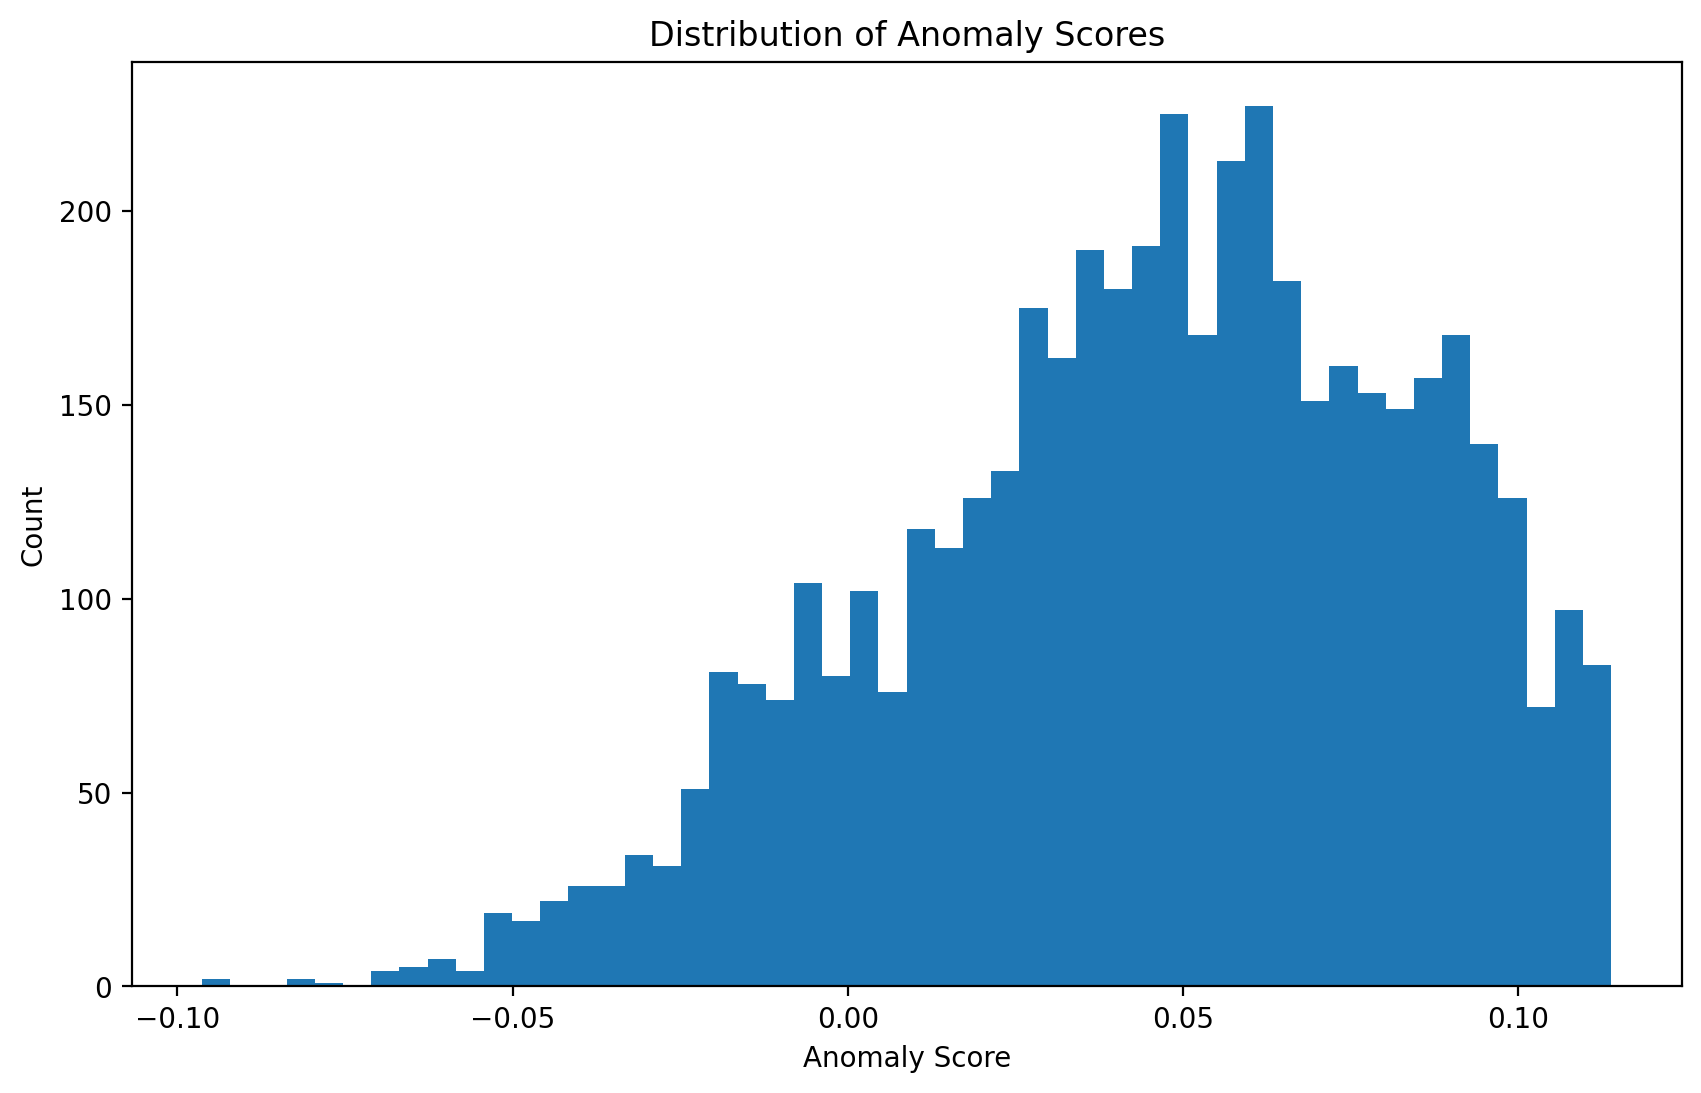

In [ ]:
# Convert target to numeric and get indices of each class
y_train_numeric = y_train.replace({"No": 0, "Yes": 1})
normal_idx = y_train_numeric[y_train_numeric == 0].index
anomaly_idx = y_train_numeric[y_train_numeric == 1].index

# Calculate contamination (proportion of anomalies in the dataset)
contamination = len(anomaly_idx) / len(y_train)

# Create and train Isolation Forest
iso_forest = Pipeline(
    [
        ("preprocess", scaled_preprocessing),
        (
            "model",
            IsolationForest(
                contamination=contamination, random_state=42, n_estimators=100
            ),
        ),
    ]
)

# Fit the model
iso_forest.fit(X_train)

# Get predictions (-1 for anomalies, 1 for normal)
y_pred_iso = iso_forest.predict(X_test)

# Convert predictions to match our labels (1 for Yes, 0 for No)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Print results
print("Isolation Forest Classification Report:")
print(classification_report(y_test.replace({"No": 0, "Yes": 1}), y_pred_iso))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test.replace({"No": 0, "Yes": 1}), y_pred_iso))

# Optional: Plot decision function scores
decision_scores = iso_forest.decision_function(X_test)
plt.figure(figsize=(10, 6))
plt.hist(decision_scores, bins=50)
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()

OneClassSVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      4043
           1       0.21      0.15      0.17       662

    accuracy                           0.80      4705
   macro avg       0.54      0.53      0.53      4705
weighted avg       0.77      0.80      0.79      4705


Confusion Matrix:
[[3669  374]
 [ 564   98]]


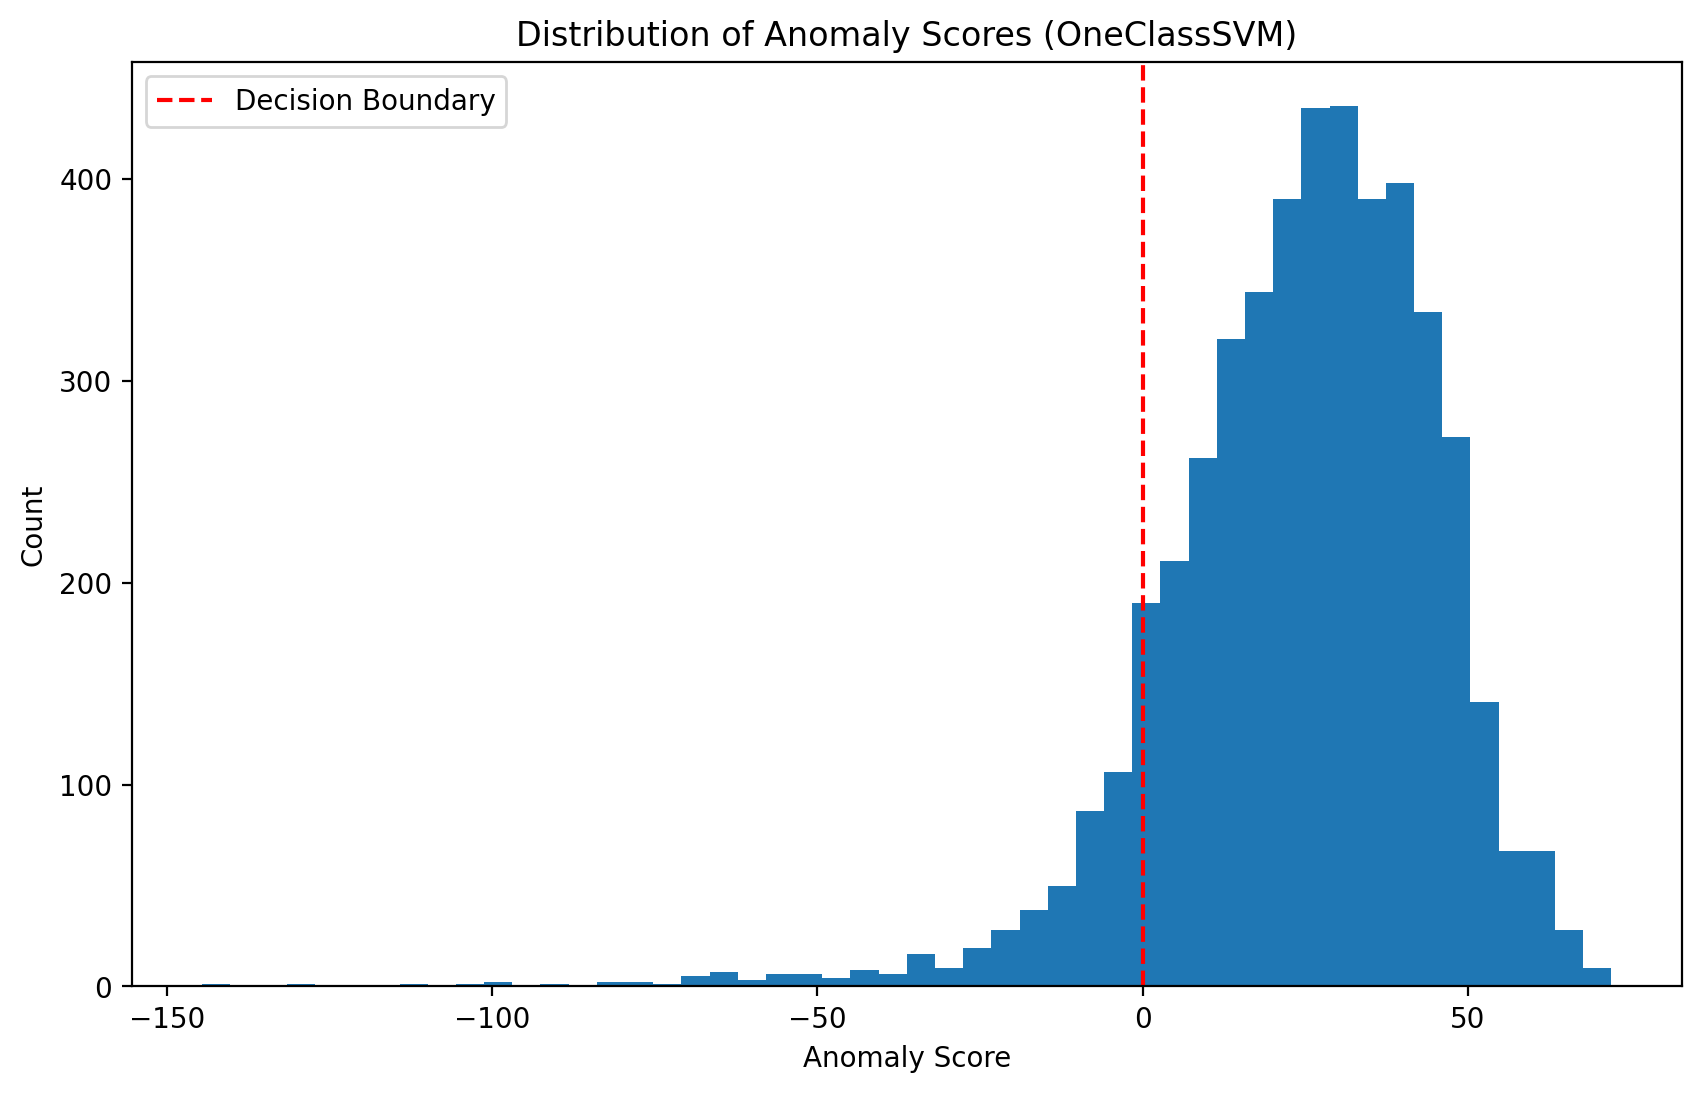

In [ ]:
# Train on the majority class only (people without bank accounts)
normal_samples = X_train[y_train == "No"]
normal_samples_preprocessed = scaled_preprocessing.fit_transform(normal_samples)

# Create and train OneClassSVM
one_class_svm = OneClassSVM(
    kernel="rbf",  # Radial basis function kernel
    nu=0.1,  # An upper bound on the fraction of training errors
    gamma="scale",  # Kernel coefficient
)

# Fit the model on normal samples only
one_class_svm.fit(normal_samples_preprocessed)

# Transform test data and get predictions
X_test_preprocessed = scaled_preprocessing.transform(X_test)
y_pred_svm = one_class_svm.predict(X_test_preprocessed)

# Convert predictions to match our labels (1 for Yes, 0 for No)
# OneClassSVM returns: 1 for normal, -1 for anomaly
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

# Print results
print("OneClassSVM Classification Report:")
print(classification_report(y_test.replace({"No": 0, "Yes": 1}), y_pred_svm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test.replace({"No": 0, "Yes": 1}), y_pred_svm))

# Optional: Plot decision function scores
decision_scores = one_class_svm.decision_function(X_test_preprocessed)
plt.figure(figsize=(10, 6))
plt.hist(decision_scores, bins=50)
plt.axvline(x=0, color="r", linestyle="--", label="Decision Boundary")
plt.title("Distribution of Anomaly Scores (OneClassSVM)")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.show()

#### Undersamplinging Approach

In [ ]:
# Apply undersampling to balance the classes
undersampler = RandomUnderSampler(random_state=42)
X_train_preprocessed = scaled_preprocessing.fit_transform(X_train)
X_train_under, y_train_under = undersampler.fit_resample(X_train_preprocessed, y_train)

# Check the new class distribution
print("Original class distribution:")
print(y_train.value_counts())
print("\nUndersampled class distribution:")
print(pd.Series(y_train_under).value_counts())

# Train Random Forest on undersampled data
rf_under = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
)

rf_under.fit(X_train_under, y_train_under)

# Make predictions on test set
X_test_transformed = scaled_preprocessing.transform(X_test)
y_pred_rf_under = rf_under.predict(X_test_transformed)

# Print results
print("\nRandom Forest Classification Report with Undersampling:")
print(classification_report(y_test, y_pred_rf_under))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_under))

Original class distribution:
bank_account
No     16169
Yes     2650
Name: count, dtype: int64

Undersampled class distribution:
bank_account
No     2650
Yes    2650
Name: count, dtype: int64

Random Forest Classification Report with Undersampling:
              precision    recall  f1-score   support

          No       0.94      0.79      0.86      4043
         Yes       0.35      0.69      0.47       662

    accuracy                           0.78      4705
   macro avg       0.65      0.74      0.66      4705
weighted avg       0.86      0.78      0.80      4705


Confusion Matrix:
[[3205  838]
 [ 204  458]]


In [ ]:
# Finally, we can improve the best model we had until now

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split":[2, 5, 10],
    "min_samples_leaf":[1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"],
}

rf_weighted_cv = Pipeline(
    [
        ("preprocess", scaled_preprocessing),
        (
            "RandomSearchCV",
            RandomizedSearchCV(
                RandomForestClassifier(random_state=42),
                param_grid, cv=5, n_jobs=-1, n_iter=10, verbose=1, random_state=42,
            ),
        ),
    ]
)

# Train the random search
rf_weighted_cv.fit(X_train, y_train)

In [ ]:
# prompt: Use the best model and create an ensemble voting classifier with XGBOOst

# Assuming xgb_model, rf_model_smote, and rf_weighted are already trained as in the provided code.
estimators = [
    ('xgb', xgb_model),
    ('rf_smote', rf_model_smote),
    ('rf_weighted', rf_weighted)
]

ensemble = VotingClassifier(estimators=estimators, voting='soft') # 'soft' for probability-based voting

# Convert y_train_balanced to numeric if it's not already
y_train_balanced_numeric = pd.Series(y_train_balanced).replace({"No": 0, "Yes": 1})


# Fit the ensemble on the training data with SMOTE-balanced data
ensemble.fit(X_train_balanced, y_train_balanced_numeric)


# Make predictions on the test set
X_test_transformed = scaled_preprocessing.transform(X_test)

y_pred_ensemble = ensemble.predict(X_test_transformed)


# Evaluate the ensemble
print("Ensemble Classification Report:")
print(classification_report(y_test.replace({"No": 0, "Yes": 1}), y_pred_ensemble))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test.replace({"No": 0, "Yes": 1}), y_pred_ensemble))